In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from opensoundscape.annotations import categorical_to_one_hot
import matplotlib.pyplot as plt
from opensoundscape.torch.models.cnn import load_model


Bad key "text.kerning_factor" on line 4 in
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Read the train/validation and test data

In [28]:
name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/test"
#_TRAINING.csv"
train_val_df = pd.read_csv(name + '_TRAINING.csv')
test_df = pd.read_csv(name + '_TESTING.csv')
model_save = './model/' + 'test_for_reformed_dataset/'

In [29]:
test_df

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,0.0,3.0,44100,Celeus grammicus
1,1,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,3.0,6.0,44100,Celeus grammicus
2,2,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,6.0,9.0,44100,no bird
3,3,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,9.0,12.0,44100,Celeus grammicus
4,4,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,12.0,15.0,44100,Celeus grammicus
...,...,...,...,...,...,...
6432,6432,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,15.0,18.0,44100,Tolmomyias sulphurescens
6433,6433,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,18.0,21.0,44100,no bird
6434,6434,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,21.0,24.0,44100,Tolmomyias sulphurescens
6435,6435,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,24.0,27.0,44100,Tolmomyias sulphurescens


In [30]:
test_df.shape

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6437, 6)

In [31]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

./Cosmos_data/Training/XC100027 - Southern Nightingale-Wren - Microcerculus marginatus_18.0.wav


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


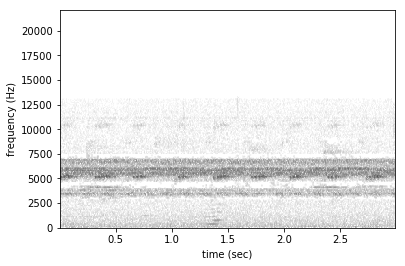

In [32]:
file = train_val_df["file"].iloc[6]
print(file)
Spectrogram.from_audio(Audio.from_file(file)).plot()

In [33]:
train_val_df["filename"] = train_val_df["file"].apply(lambda x: x.split("/")[-1])
train_val_df.head()

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,./Cosmos_data/Training/XC100027 - Southern Nig...,0.0,3.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
1,1,./Cosmos_data/Training/XC100027 - Southern Nig...,3.0,6.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
2,2,./Cosmos_data/Training/XC100027 - Southern Nig...,6.0,9.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
3,3,./Cosmos_data/Training/XC100027 - Southern Nig...,9.0,12.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
4,4,./Cosmos_data/Training/XC100027 - Southern Nig...,12.0,15.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...


In [34]:
test_df.head()

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,0.0,3.0,44100,Celeus grammicus
1,1,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,3.0,6.0,44100,Celeus grammicus
2,2,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,6.0,9.0,44100,no bird
3,3,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,9.0,12.0,44100,Celeus grammicus
4,4,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,12.0,15.0,44100,Celeus grammicus


In [35]:
test_df["filename"] = test_df["file"].apply(lambda x: x.split("/")[-1])
test_df.head()

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,0.0,3.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
1,1,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,3.0,6.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
2,2,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,6.0,9.0,44100,no bird,XC87449 - Scaly-breasted Woodpecker - Celeus g...
3,3,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,9.0,12.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
4,4,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,12.0,15.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...


In [36]:
train_val_df = train_val_df[~train_val_df["filename"].isin(test_df["filename"])]
test_df.merge(train_val_df, left_on="filename", right_on="filename")

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0_x,file_x,start_time_x,end_time_x,SAMPLING RATE_x,MANUAL ID_x,filename,Unnamed: 0_y,file_y,start_time_y,end_time_y,SAMPLING RATE_y,MANUAL ID_y


In [37]:
def remove_denoise_audio(x):
    return x.replace("temp_clips", "temp_clips - Copy")


#train_val_df["file"] = train_val_df["file"].apply(remove_denoise_audio)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Check counts of the different classes in both the dataframes

In [38]:
import os


In [40]:
no_bird = pd.read_csv(os.getcwd()+'\\none_test.csv')
no_bird["MANUAL ID"] = "Absent"
#other_bird = 
other_bird = train_val_df[train_val_df["MANUAL ID"] == "other"]#.sample(4000)
train_val_df = train_val_df[~train_val_df["MANUAL ID"].isin(["other"])]






train_val_df = train_val_df.append(no_bird).append(other_bird)
train_val_df

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,./Cosmos_data/Training/XC100027 - Southern Nig...,0.0,3.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
1,1,./Cosmos_data/Training/XC100027 - Southern Nig...,3.0,6.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
2,2,./Cosmos_data/Training/XC100027 - Southern Nig...,6.0,9.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
3,3,./Cosmos_data/Training/XC100027 - Southern Nig...,9.0,12.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
4,4,./Cosmos_data/Training/XC100027 - Southern Nig...,12.0,15.0,44100,Microcerculus marginatus,XC100027 - Southern Nightingale-Wren - Microce...
...,...,...,...,...,...,...,...
1012,1012,./temp_clips/Absent/20190705_171000_15.WAV,24.0,27.0,384000,Absent,NaN
1013,1013,./temp_clips/Absent/20190705_171000_16.WAV,27.0,30.0,384000,Absent,NaN
1014,1014,./temp_clips/Absent/20190705_171000_17.WAV,30.0,33.0,384000,Absent,NaN
1015,1015,./temp_clips/Absent/20190705_171000_18.WAV,33.0,36.0,384000,Absent,NaN


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


./temp_clips/Absent/5D1B1608_5.WAV


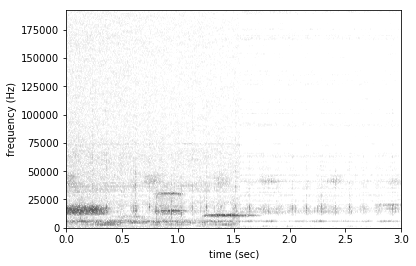

In [41]:
file = no_bird["file"].iloc[10]
print(file)
Spectrogram.from_audio(Audio.from_file(file)).plot()

In [42]:
species = np.unique(train_val_df['MANUAL ID'])
species

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Absent', 'Celeus grammicus', 'Microcerculus marginatus',
       'Myioborus miniatus', 'Ramphastos tucanus', 'Thraupis episcopus',
       'Tolmomyias sulphurescens', 'Trogon viridis', 'Turdus leucomelas',
       'Xiphorhynchus guttatus', 'Zonotrichia capensis', 'no bird'],
      dtype=object)

In [43]:
test_df

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,0.0,3.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
1,1,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,3.0,6.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
2,2,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,6.0,9.0,44100,no bird,XC87449 - Scaly-breasted Woodpecker - Celeus g...
3,3,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,9.0,12.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
4,4,./Cosmos_data/Testing/XC87449 - Scaly-breasted...,12.0,15.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
...,...,...,...,...,...,...,...
6432,6432,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,15.0,18.0,44100,Tolmomyias sulphurescens,XC27942 - Yellow-olive Flatbill - Tolmomyias s...
6433,6433,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,18.0,21.0,44100,no bird,XC27942 - Yellow-olive Flatbill - Tolmomyias s...
6434,6434,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,21.0,24.0,44100,Tolmomyias sulphurescens,XC27942 - Yellow-olive Flatbill - Tolmomyias s...
6435,6435,./Cosmos_data/Testing/XC27942 - Yellow-olive F...,24.0,27.0,44100,Tolmomyias sulphurescens,XC27942 - Yellow-olive Flatbill - Tolmomyias s...


In [48]:
#TODO FIX THIS
species = classes = np.unique(train_val_df['MANUAL ID'])
def fix_classes(label):
    if (not label in species or label=="no bird"):
        return "no bird"
    return label
test_df['MANUAL ID'] = test_df["MANUAL ID"].apply(fix_classes)

In [49]:
train_val_df['MANUAL ID'].value_counts()

no bird                     7451
Microcerculus marginatus    4031
Zonotrichia capensis        3766
Turdus leucomelas           3371
Tolmomyias sulphurescens    3338
Ramphastos tucanus          3169
Xiphorhynchus guttatus      3045
Trogon viridis              2722
Myioborus miniatus          1030
Absent                      1017
Thraupis episcopus           926
Celeus grammicus             482
Name: MANUAL ID, dtype: int64

In [50]:
test_df['MANUAL ID'].value_counts()

no bird                     2709
Ramphastos tucanus           552
Turdus leucomelas            493
Microcerculus marginatus     439
Zonotrichia capensis         398
Tolmomyias sulphurescens     368
Trogon viridis               357
Xiphorhynchus guttatus       335
Myioborus miniatus           314
Thraupis episcopus           248
Celeus grammicus             224
Name: MANUAL ID, dtype: int64

### Changing species' names to a simpler version for convenience

In [51]:
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = 'Toucan'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Flycatcher'), 'MANUAL ID'] = 'Flycatcher'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Thrush'), 'MANUAL ID'] = 'Thrush'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = 'Vireo'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = 'Antwren'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = 'Tanager'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = 'Kingbird'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = 'Tody-Tyrant'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = 'Hummingbird'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = 'Antshrike'

In [52]:
other_bird = train_val_df[~(train_val_df["MANUAL ID"].isin(classes))]
other_bird["MANUAL ID"] = "bird"

### Remove rows from dataframes which are not the species of our interest

In [53]:
classes = np.unique(test_df['MANUAL ID'])#["Zonotrichia capensis", "other", "bird"] ##['Antwren', 'Antshrike', 'Toucan', 'Vireo', 'Kingbird', 'Tody-Tyrant', 'None']
train_val_df[~(train_val_df["MANUAL ID"].isin(classes))]["MANUAL ID"] = "bird"
train_val_df = train_val_df[train_val_df["MANUAL ID"].isin(classes)]
train_val_df = train_val_df.append(other_bird)
test_df = test_df[test_df["MANUAL ID"].isin(classes)]
print('Classwise Counts for train/val data:')
print(train_val_df['MANUAL ID'].value_counts())
print('\nClasswise  Counts for test data:')
print(test_df['MANUAL ID'].value_counts())

Classwise Counts for train/val data:
no bird                     7451
Microcerculus marginatus    4031
Zonotrichia capensis        3766
Turdus leucomelas           3371
Tolmomyias sulphurescens    3338
Ramphastos tucanus          3169
Xiphorhynchus guttatus      3045
Trogon viridis              2722
Myioborus miniatus          1030
Thraupis episcopus           926
Celeus grammicus             482
Name: MANUAL ID, dtype: int64

Classwise  Counts for test data:
no bird                     2709
Ramphastos tucanus           552
Turdus leucomelas            493
Microcerculus marginatus     439
Zonotrichia capensis         398
Tolmomyias sulphurescens     368
Trogon viridis               357
Xiphorhynchus guttatus       335
Myioborus miniatus           314
Thraupis episcopus           248
Celeus grammicus             224
Name: MANUAL ID, dtype: int64


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Convert the train/val and test data to one-hot representations of the classes

In [54]:
# Train/val
one_hot_labels, train_classes = categorical_to_one_hot(train_val_df[['MANUAL ID']].values)
train_val_df = pd.DataFrame(index=train_val_df['file'],data=one_hot_labels,columns=train_classes)

# Test
one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)

In [55]:
test_df

,Thraupis episcopus,Celeus grammicus,Turdus leucomelas,Xiphorhynchus guttatus,Ramphastos tucanus,Trogon viridis,Tolmomyias sulphurescens,no bird,Zonotrichia capensis,Myioborus miniatus,Microcerculus marginatus
file,,,,,,,,,,,
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,0,0,1,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,0,0,1,0,0,0,0


### Split the trainining/validation dataframe into training and validation sets

In [56]:
train_df, valid_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
print("Number of training examples : ", train_df.shape[0])
print("Number of validation examples : ", valid_df.shape[0])
print("Number of test examples : ", test_df.shape[0])

Number of training examples :  26664
Number of validation examples :  6667
Number of test examples :  6437


### Prepare the training and validation set for the CNN model

In [58]:
train_dataset = CnnPreprocessor(df=train_df)
train_dataset.augmentation_on()
train_dataset.actions.load_audio.set(sample_rate=44100)
valid_dataset = CnnPreprocessor(df=valid_df)
valid_dataset.augmentation_on()
valid_dataset.actions.load_audio.set(sample_rate=44100)

### Create the Resnet-18 Multiclass model and train it

In [59]:
model = cnn.Resnet18Multiclass(train_classes)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


created PytorchModel model object with 11 classes


In [60]:
#model.optimizer_params = {
#        "feature": {  # optimizer parameters for feature extraction layers
#            # "params": self.network.feature.parameters(),
#            "lr": 0.001,
#            "momentum": 0.9,
#            "weight_decay": 0.0005,
#        },
#        "classifier": {  # optimizer parameters for classification layers
#            # "params": self.network.classifier.parameters(),
#            "lr": 0.0001,
#            "momentum": 0.9,
#            "weight_decay": 0.0005,
#        },
#    }

In [61]:
#name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/model/automated_cosmos_tweety_to_file_warblar_no_bird_test_4_5_epochs/"
#model_save = name
#model_save

In [62]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_init_loss_fn',
 '_init_optimizer',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_set_t

In [64]:
model.sampler = 'imbalanced'
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path=model_save,
    batch_size=16,
    save_interval=100,
    num_workers=6,
    epochs=10
)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch: 0 [batch 0/1667 (0.00%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 14.914


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 10/1667 (0.60%)] 
	Jacc: 0.091 Hamm: 0.091 DistLoss: 14.507


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 20/1667 (1.20%)] 
	Jacc: 0.144 Hamm: 0.080 DistLoss: 14.199


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 30/1667 (1.80%)] 
	Jacc: 0.250 Hamm: 0.080 DistLoss: 13.506


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 40/1667 (2.40%)] 
	Jacc: 0.136 Hamm: 0.091 DistLoss: 13.274


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 50/1667 (3.00%)] 
	Jacc: 0.318 Hamm: 0.074 DistLoss: 12.817


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 60/1667 (3.60%)] 
	Jacc: 0.114 Hamm: 0.091 DistLoss: 12.558


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 70/1667 (4.20%)] 
	Jacc: 0.273 Hamm: 0.080 DistLoss: 12.323


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 80/1667 (4.80%)] 
	Jacc: 0.318 Hamm: 0.057 DistLoss: 12.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 90/1667 (5.40%)] 
	Jacc: 0.273 Hamm: 0.080 DistLoss: 11.974


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 100/1667 (6.00%)] 
	Jacc: 0.303 Hamm: 0.085 DistLoss: 11.781
Epoch: 0 [batch 110/1667 (6.60%)] 
	Jacc: 0.295 Hamm: 0.068 DistLoss: 11.687


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 120/1667 (7.20%)] 
	Jacc: 0.227 Hamm: 0.085 DistLoss: 11.561
Epoch: 0 [batch 130/1667 (7.80%)] 
	Jacc: 0.364 Hamm: 0.074 DistLoss: 11.461
Epoch: 0 [batch 140/1667 (8.40%)] 
	Jacc: 0.235 Hamm: 0.080 DistLoss: 11.392


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 150/1667 (9.00%)] 
	Jacc: 0.367 Hamm: 0.068 DistLoss: 11.320


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 160/1667 (9.60%)] 
	Jacc: 0.273 Hamm: 0.097 DistLoss: 11.215
Epoch: 0 [batch 170/1667 (10.20%)] 
	Jacc: 0.106 Hamm: 0.080 DistLoss: 11.131


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 180/1667 (10.80%)] 
	Jacc: 0.432 Hamm: 0.057 DistLoss: 11.002


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 190/1667 (11.40%)] 
	Jacc: 0.318 Hamm: 0.074 DistLoss: 10.889


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 200/1667 (12.00%)] 
	Jacc: 0.333 Hamm: 0.062 DistLoss: 10.743


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 210/1667 (12.60%)] 
	Jacc: 0.409 Hamm: 0.051 DistLoss: 10.729


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 220/1667 (13.20%)] 
	Jacc: 0.258 Hamm: 0.074 DistLoss: 10.682


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 230/1667 (13.80%)] 
	Jacc: 0.311 Hamm: 0.062 DistLoss: 10.564


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 240/1667 (14.40%)] 
	Jacc: 0.276 Hamm: 0.062 DistLoss: 10.491


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 250/1667 (15.00%)] 
	Jacc: 0.447 Hamm: 0.045 DistLoss: 10.399


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 260/1667 (15.60%)] 
	Jacc: 0.364 Hamm: 0.062 DistLoss: 10.332


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 270/1667 (16.20%)] 
	Jacc: 0.288 Hamm: 0.062 DistLoss: 10.313


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 280/1667 (16.80%)] 
	Jacc: 0.288 Hamm: 0.062 DistLoss: 10.258


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 290/1667 (17.40%)] 
	Jacc: 0.359 Hamm: 0.074 DistLoss: 10.205


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 300/1667 (18.00%)] 
	Jacc: 0.312 Hamm: 0.074 DistLoss: 10.179


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 310/1667 (18.60%)] 
	Jacc: 0.273 Hamm: 0.074 DistLoss: 10.126


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 320/1667 (19.20%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 10.056
Epoch: 0 [batch 330/1667 (19.80%)] 
	Jacc: 0.273 Hamm: 0.080 DistLoss: 9.987


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 340/1667 (20.40%)] 
	Jacc: 0.530 Hamm: 0.057 DistLoss: 9.925
Epoch: 0 [batch 350/1667 (21.00%)] 
	Jacc: 0.273 Hamm: 0.068 DistLoss: 9.856


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 360/1667 (21.60%)] 
	Jacc: 0.356 Hamm: 0.057 DistLoss: 9.834


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 370/1667 (22.20%)] 
	Jacc: 0.318 Hamm: 0.085 DistLoss: 9.802


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 380/1667 (22.80%)] 
	Jacc: 0.621 Hamm: 0.040 DistLoss: 9.766


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 390/1667 (23.40%)] 
	Jacc: 0.280 Hamm: 0.085 DistLoss: 9.727


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 400/1667 (24.00%)] 
	Jacc: 0.288 Hamm: 0.074 DistLoss: 9.671


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 410/1667 (24.60%)] 
	Jacc: 0.288 Hamm: 0.068 DistLoss: 9.627


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 420/1667 (25.19%)] 
	Jacc: 0.303 Hamm: 0.085 DistLoss: 9.598


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 430/1667 (25.79%)] 
	Jacc: 0.318 Hamm: 0.074 DistLoss: 9.559


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 440/1667 (26.39%)] 
	Jacc: 0.530 Hamm: 0.034 DistLoss: 9.495


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 450/1667 (26.99%)] 
	Jacc: 0.371 Hamm: 0.062 DistLoss: 9.458


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 460/1667 (27.59%)] 
	Jacc: 0.324 Hamm: 0.068 DistLoss: 9.429


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 470/1667 (28.19%)] 
	Jacc: 0.227 Hamm: 0.074 DistLoss: 9.410


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 480/1667 (28.79%)] 
	Jacc: 0.185 Hamm: 0.102 DistLoss: 9.400


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 490/1667 (29.39%)] 
	Jacc: 0.227 Hamm: 0.091 DistLoss: 9.363


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 500/1667 (29.99%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 9.314


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 510/1667 (30.59%)] 
	Jacc: 0.242 Hamm: 0.068 DistLoss: 9.281


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 520/1667 (31.19%)] 
	Jacc: 0.356 Hamm: 0.040 DistLoss: 9.253


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 530/1667 (31.79%)] 
	Jacc: 0.182 Hamm: 0.074 DistLoss: 9.229


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 540/1667 (32.39%)] 
	Jacc: 0.306 Hamm: 0.074 DistLoss: 9.187


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 550/1667 (32.99%)] 
	Jacc: 0.348 Hamm: 0.057 DistLoss: 9.159


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 560/1667 (33.59%)] 
	Jacc: 0.333 Hamm: 0.051 DistLoss: 9.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 570/1667 (34.19%)] 
	Jacc: 0.439 Hamm: 0.051 DistLoss: 9.111


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 580/1667 (34.79%)] 
	Jacc: 0.417 Hamm: 0.068 DistLoss: 9.082
Epoch: 0 [batch 590/1667 (35.39%)] 
	Jacc: 0.394 Hamm: 0.062 DistLoss: 9.058


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 600/1667 (35.99%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 9.035


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 610/1667 (36.59%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 9.009


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 620/1667 (37.19%)] 
	Jacc: 0.230 Hamm: 0.085 DistLoss: 8.996


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 630/1667 (37.79%)] 
	Jacc: 0.324 Hamm: 0.080 DistLoss: 8.971


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 640/1667 (38.39%)] 
	Jacc: 0.468 Hamm: 0.057 DistLoss: 8.943


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 650/1667 (38.99%)] 
	Jacc: 0.303 Hamm: 0.080 DistLoss: 8.931


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 660/1667 (39.59%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 8.886
Epoch: 0 [batch 670/1667 (40.19%)] 
	Jacc: 0.182 Hamm: 0.085 DistLoss: 8.871


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 680/1667 (40.79%)] 
	Jacc: 0.555 Hamm: 0.045 DistLoss: 8.830


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 690/1667 (41.39%)] 
	Jacc: 0.303 Hamm: 0.074 DistLoss: 8.808


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 700/1667 (41.99%)] 
	Jacc: 0.470 Hamm: 0.057 DistLoss: 8.781


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 710/1667 (42.59%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 8.765


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 720/1667 (43.19%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 8.743


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 730/1667 (43.79%)] 
	Jacc: 0.409 Hamm: 0.051 DistLoss: 8.736


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 740/1667 (44.39%)] 
	Jacc: 0.288 Hamm: 0.068 DistLoss: 8.723


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 750/1667 (44.99%)] 
	Jacc: 0.350 Hamm: 0.045 DistLoss: 8.701


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 760/1667 (45.59%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 8.668


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 770/1667 (46.19%)] 
	Jacc: 0.394 Hamm: 0.074 DistLoss: 8.648


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 780/1667 (46.79%)] 
	Jacc: 0.571 Hamm: 0.057 DistLoss: 8.634


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 790/1667 (47.39%)] 
	Jacc: 0.258 Hamm: 0.091 DistLoss: 8.626


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 800/1667 (47.99%)] 
	Jacc: 0.341 Hamm: 0.062 DistLoss: 8.597


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 810/1667 (48.59%)] 
	Jacc: 0.220 Hamm: 0.080 DistLoss: 8.567


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 820/1667 (49.19%)] 
	Jacc: 0.758 Hamm: 0.017 DistLoss: 8.543


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 830/1667 (49.79%)] 
	Jacc: 0.476 Hamm: 0.051 DistLoss: 8.528


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 840/1667 (50.39%)] 
	Jacc: 0.591 Hamm: 0.057 DistLoss: 8.505
Epoch: 0 [batch 850/1667 (50.99%)] 
	Jacc: 0.212 Hamm: 0.080 DistLoss: 8.484


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 860/1667 (51.59%)] 
	Jacc: 0.077 Hamm: 0.102 DistLoss: 8.479


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 870/1667 (52.19%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 8.458


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 880/1667 (52.79%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 8.464


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 890/1667 (53.39%)] 
	Jacc: 0.583 Hamm: 0.017 DistLoss: 8.461


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 900/1667 (53.99%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 8.450


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 910/1667 (54.59%)] 
	Jacc: 0.333 Hamm: 0.062 DistLoss: 8.432


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 920/1667 (55.19%)] 
	Jacc: 0.348 Hamm: 0.097 DistLoss: 8.420
Epoch: 0 [batch 930/1667 (55.79%)] 
	Jacc: 0.323 Hamm: 0.051 DistLoss: 8.408


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 940/1667 (56.39%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 8.395


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 950/1667 (56.99%)] 
	Jacc: 0.159 Hamm: 0.068 DistLoss: 8.378


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 960/1667 (57.59%)] 
	Jacc: 0.538 Hamm: 0.045 DistLoss: 8.358


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 970/1667 (58.19%)] 
	Jacc: 0.452 Hamm: 0.040 DistLoss: 8.333


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 980/1667 (58.79%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 8.321
Epoch: 0 [batch 990/1667 (59.39%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 8.302


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1000/1667 (59.99%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 8.290


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1010/1667 (60.59%)] 
	Jacc: 0.424 Hamm: 0.051 DistLoss: 8.278


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1020/1667 (61.19%)] 
	Jacc: 0.318 Hamm: 0.062 DistLoss: 8.254
Epoch: 0 [batch 1030/1667 (61.79%)] 
	Jacc: 0.220 Hamm: 0.068 DistLoss: 8.231


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1040/1667 (62.39%)] 
	Jacc: 0.417 Hamm: 0.068 DistLoss: 8.230


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1050/1667 (62.99%)] 
	Jacc: 0.568 Hamm: 0.040 DistLoss: 8.217


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1060/1667 (63.59%)] 
	Jacc: 0.500 Hamm: 0.057 DistLoss: 8.204
Epoch: 0 [batch 1070/1667 (64.19%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 8.185


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1080/1667 (64.79%)] 
	Jacc: 0.462 Hamm: 0.057 DistLoss: 8.165


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1090/1667 (65.39%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 8.153


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1100/1667 (65.99%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 8.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1110/1667 (66.59%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 8.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1120/1667 (67.19%)] 
	Jacc: 0.455 Hamm: 0.045 DistLoss: 8.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1130/1667 (67.79%)] 
	Jacc: 0.295 Hamm: 0.062 DistLoss: 8.127


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1140/1667 (68.39%)] 
	Jacc: 0.462 Hamm: 0.034 DistLoss: 8.124


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1150/1667 (68.99%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 8.110


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1160/1667 (69.59%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 8.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1170/1667 (70.19%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 8.082


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1180/1667 (70.79%)] 
	Jacc: 0.394 Hamm: 0.034 DistLoss: 8.063


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1190/1667 (71.39%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 8.045


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1200/1667 (71.99%)] 
	Jacc: 0.258 Hamm: 0.068 DistLoss: 8.039


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1210/1667 (72.59%)] 
	Jacc: 0.265 Hamm: 0.074 DistLoss: 8.035


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1220/1667 (73.19%)] 
	Jacc: 0.424 Hamm: 0.040 DistLoss: 8.035


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1230/1667 (73.79%)] 
	Jacc: 0.515 Hamm: 0.051 DistLoss: 8.015


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1240/1667 (74.39%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 8.002


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1250/1667 (74.99%)] 
	Jacc: 0.264 Hamm: 0.080 DistLoss: 7.991


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1260/1667 (75.58%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 7.975


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1270/1667 (76.18%)] 
	Jacc: 0.355 Hamm: 0.051 DistLoss: 7.970


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1280/1667 (76.78%)] 
	Jacc: 0.241 Hamm: 0.074 DistLoss: 7.966


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1290/1667 (77.38%)] 
	Jacc: 0.455 Hamm: 0.068 DistLoss: 7.960
Epoch: 0 [batch 1300/1667 (77.98%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 7.953


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1310/1667 (78.58%)] 
	Jacc: 0.409 Hamm: 0.045 DistLoss: 7.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1320/1667 (79.18%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 7.944


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1330/1667 (79.78%)] 
	Jacc: 0.497 Hamm: 0.017 DistLoss: 7.924


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1340/1667 (80.38%)] 
	Jacc: 0.455 Hamm: 0.040 DistLoss: 7.913


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1350/1667 (80.98%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 7.898
Epoch: 0 [batch 1360/1667 (81.58%)] 
	Jacc: 0.220 Hamm: 0.085 DistLoss: 7.893


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1370/1667 (82.18%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 7.875


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1380/1667 (82.78%)] 
	Jacc: 0.356 Hamm: 0.051 DistLoss: 7.863


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1390/1667 (83.38%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 7.850


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1400/1667 (83.98%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 7.831


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1410/1667 (84.58%)] 
	Jacc: 0.485 Hamm: 0.062 DistLoss: 7.827


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1420/1667 (85.18%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 7.811


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1430/1667 (85.78%)] 
	Jacc: 0.506 Hamm: 0.051 DistLoss: 7.800


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1440/1667 (86.38%)] 
	Jacc: 0.197 Hamm: 0.085 DistLoss: 7.795


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1450/1667 (86.98%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 7.783


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1460/1667 (87.58%)] 
	Jacc: 0.273 Hamm: 0.057 DistLoss: 7.775


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1470/1667 (88.18%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 7.767


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1480/1667 (88.78%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 7.759
Epoch: 0 [batch 1490/1667 (89.38%)] 
	Jacc: 0.659 Hamm: 0.040 DistLoss: 7.749


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1500/1667 (89.98%)] 
	Jacc: 0.409 Hamm: 0.051 DistLoss: 7.742


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1510/1667 (90.58%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 7.732


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1520/1667 (91.18%)] 
	Jacc: 0.402 Hamm: 0.051 DistLoss: 7.724


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1530/1667 (91.78%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 7.708
Epoch: 0 [batch 1540/1667 (92.38%)] 
	Jacc: 0.394 Hamm: 0.051 DistLoss: 7.695


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1550/1667 (92.98%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 7.685


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1560/1667 (93.58%)] 
	Jacc: 0.424 Hamm: 0.057 DistLoss: 7.673


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1570/1667 (94.18%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 7.661


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1580/1667 (94.78%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 7.653


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1590/1667 (95.38%)] 
	Jacc: 0.479 Hamm: 0.034 DistLoss: 7.642


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1600/1667 (95.98%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 7.629


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1610/1667 (96.58%)] 
	Jacc: 0.455 Hamm: 0.045 DistLoss: 7.623


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1620/1667 (97.18%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 7.610


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1630/1667 (97.78%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 7.605


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1640/1667 (98.38%)] 
	Jacc: 0.312 Hamm: 0.057 DistLoss: 7.597


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1650/1667 (98.98%)] 
	Jacc: 0.523 Hamm: 0.040 DistLoss: 7.588


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1660/1667 (99.58%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 7.578


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7541558952754212
	 Recall: 0.625101163296333
	 F1: 0.664241518832839
Updating best model
Epoch: 1 [batch 0/1667 (0.00%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 5.845


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 10/1667 (0.60%)] 
	Jacc: 0.447 Hamm: 0.057 DistLoss: 6.642


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 20/1667 (1.20%)] 
	Jacc: 0.424 Hamm: 0.051 DistLoss: 6.811


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 30/1667 (1.80%)] 
	Jacc: 0.288 Hamm: 0.074 DistLoss: 7.134


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 40/1667 (2.40%)] 
	Jacc: 0.462 Hamm: 0.051 DistLoss: 6.930


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 50/1667 (3.00%)] 
	Jacc: 0.364 Hamm: 0.062 DistLoss: 6.916


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 60/1667 (3.60%)] 
	Jacc: 0.371 Hamm: 0.051 DistLoss: 6.725


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 70/1667 (4.20%)] 
	Jacc: 0.394 Hamm: 0.045 DistLoss: 6.631


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 80/1667 (4.80%)] 
	Jacc: 0.598 Hamm: 0.028 DistLoss: 6.545


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 90/1667 (5.40%)] 
	Jacc: 0.409 Hamm: 0.051 DistLoss: 6.547


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 100/1667 (6.00%)] 
	Jacc: 0.311 Hamm: 0.062 DistLoss: 6.545


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 110/1667 (6.60%)] 
	Jacc: 0.485 Hamm: 0.057 DistLoss: 6.410


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 120/1667 (7.20%)] 
	Jacc: 0.405 Hamm: 0.051 DistLoss: 6.422


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 130/1667 (7.80%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 6.486
Epoch: 1 [batch 140/1667 (8.40%)] 
	Jacc: 0.356 Hamm: 0.034 DistLoss: 6.464


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 150/1667 (9.00%)] 
	Jacc: 0.621 Hamm: 0.040 DistLoss: 6.399
Epoch: 1 [batch 160/1667 (9.60%)] 
	Jacc: 0.497 Hamm: 0.040 DistLoss: 6.488


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 170/1667 (10.20%)] 
	Jacc: 0.273 Hamm: 0.085 DistLoss: 6.493


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 180/1667 (10.80%)] 
	Jacc: 0.470 Hamm: 0.057 DistLoss: 6.490
Epoch: 1 [batch 190/1667 (11.40%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 6.476


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 200/1667 (12.00%)] 
	Jacc: 0.455 Hamm: 0.040 DistLoss: 6.457


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 210/1667 (12.60%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 6.407


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 220/1667 (13.20%)] 
	Jacc: 0.338 Hamm: 0.074 DistLoss: 6.421


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 230/1667 (13.80%)] 
	Jacc: 0.409 Hamm: 0.062 DistLoss: 6.465


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 240/1667 (14.40%)] 
	Jacc: 0.614 Hamm: 0.040 DistLoss: 6.443


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 250/1667 (15.00%)] 
	Jacc: 0.220 Hamm: 0.085 DistLoss: 6.448


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 260/1667 (15.60%)] 
	Jacc: 0.371 Hamm: 0.080 DistLoss: 6.439


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 270/1667 (16.20%)] 
	Jacc: 0.364 Hamm: 0.057 DistLoss: 6.424


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 280/1667 (16.80%)] 
	Jacc: 0.621 Hamm: 0.023 DistLoss: 6.438


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 290/1667 (17.40%)] 
	Jacc: 0.486 Hamm: 0.045 DistLoss: 6.408


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 300/1667 (18.00%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 6.405


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 310/1667 (18.60%)] 
	Jacc: 0.326 Hamm: 0.085 DistLoss: 6.403
Epoch: 1 [batch 320/1667 (19.20%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 6.424


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 330/1667 (19.80%)] 
	Jacc: 0.311 Hamm: 0.074 DistLoss: 6.402


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 340/1667 (20.40%)] 
	Jacc: 0.417 Hamm: 0.045 DistLoss: 6.387


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 350/1667 (21.00%)] 
	Jacc: 0.470 Hamm: 0.068 DistLoss: 6.398
Epoch: 1 [batch 360/1667 (21.60%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 6.370


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 370/1667 (22.20%)] 
	Jacc: 0.447 Hamm: 0.057 DistLoss: 6.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 380/1667 (22.80%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 6.299


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 390/1667 (23.40%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 6.254


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 400/1667 (24.00%)] 
	Jacc: 0.288 Hamm: 0.045 DistLoss: 6.281


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 410/1667 (24.60%)] 
	Jacc: 0.321 Hamm: 0.085 DistLoss: 6.290


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 420/1667 (25.19%)] 
	Jacc: 0.356 Hamm: 0.051 DistLoss: 6.293


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 430/1667 (25.79%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 6.275


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 440/1667 (26.39%)] 
	Jacc: 0.485 Hamm: 0.034 DistLoss: 6.257


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 450/1667 (26.99%)] 
	Jacc: 0.364 Hamm: 0.040 DistLoss: 6.229


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 460/1667 (27.59%)] 
	Jacc: 0.386 Hamm: 0.051 DistLoss: 6.214


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 470/1667 (28.19%)] 
	Jacc: 0.424 Hamm: 0.045 DistLoss: 6.177


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 480/1667 (28.79%)] 
	Jacc: 0.492 Hamm: 0.040 DistLoss: 6.172


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 490/1667 (29.39%)] 
	Jacc: 0.333 Hamm: 0.057 DistLoss: 6.165


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 500/1667 (29.99%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 6.163


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 510/1667 (30.59%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 6.173


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 520/1667 (31.19%)] 
	Jacc: 0.379 Hamm: 0.045 DistLoss: 6.161


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 530/1667 (31.79%)] 
	Jacc: 0.455 Hamm: 0.040 DistLoss: 6.155


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 540/1667 (32.39%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 6.125


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 550/1667 (32.99%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 6.123


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 560/1667 (33.59%)] 
	Jacc: 0.394 Hamm: 0.057 DistLoss: 6.111
Epoch: 1 [batch 570/1667 (34.19%)] 
	Jacc: 0.303 Hamm: 0.062 DistLoss: 6.109


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 580/1667 (34.79%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 6.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 590/1667 (35.39%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 6.101


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 600/1667 (35.99%)] 
	Jacc: 0.318 Hamm: 0.062 DistLoss: 6.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 610/1667 (36.59%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 6.085


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 620/1667 (37.19%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 6.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 630/1667 (37.79%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 6.074


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 640/1667 (38.39%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 6.075


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 650/1667 (38.99%)] 
	Jacc: 0.614 Hamm: 0.040 DistLoss: 6.080


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 660/1667 (39.59%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 6.077


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 670/1667 (40.19%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 6.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 680/1667 (40.79%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 6.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 690/1667 (41.39%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 6.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 700/1667 (41.99%)] 
	Jacc: 0.545 Hamm: 0.057 DistLoss: 6.102


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 710/1667 (42.59%)] 
	Jacc: 0.561 Hamm: 0.057 DistLoss: 6.094
Epoch: 1 [batch 720/1667 (43.19%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 6.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 730/1667 (43.79%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 6.100


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 740/1667 (44.39%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 6.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 750/1667 (44.99%)] 
	Jacc: 0.379 Hamm: 0.062 DistLoss: 6.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 760/1667 (45.59%)] 
	Jacc: 0.712 Hamm: 0.045 DistLoss: 6.080
Epoch: 1 [batch 770/1667 (46.19%)] 
	Jacc: 0.477 Hamm: 0.040 DistLoss: 6.071


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 780/1667 (46.79%)] 
	Jacc: 0.485 Hamm: 0.028 DistLoss: 6.058


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 790/1667 (47.39%)] 
	Jacc: 0.470 Hamm: 0.074 DistLoss: 6.061


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 800/1667 (47.99%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 6.066


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 810/1667 (48.59%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 6.061


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 820/1667 (49.19%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 6.062


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 830/1667 (49.79%)] 
	Jacc: 0.561 Hamm: 0.057 DistLoss: 6.064
Epoch: 1 [batch 840/1667 (50.39%)] 
	Jacc: 0.333 Hamm: 0.051 DistLoss: 6.055


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 850/1667 (50.99%)] 
	Jacc: 0.455 Hamm: 0.057 DistLoss: 6.061


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 860/1667 (51.59%)] 
	Jacc: 0.591 Hamm: 0.045 DistLoss: 6.067
Epoch: 1 [batch 870/1667 (52.19%)] 
	Jacc: 0.464 Hamm: 0.068 DistLoss: 6.068
Epoch: 1 [batch 880/1667 (52.79%)] 
	Jacc: 0.364 Hamm: 0.080 DistLoss: 6.080
Epoch: 1 [batch 890/1667 (53.39%)] 
	Jacc: 0.409 Hamm: 0.045 DistLoss: 6.071


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 900/1667 (53.99%)] 
	Jacc: 0.667 Hamm: 0.034 DistLoss: 6.072
Epoch: 1 [batch 910/1667 (54.59%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 6.066


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 920/1667 (55.19%)] 
	Jacc: 0.750 Hamm: 0.023 DistLoss: 6.063


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 930/1667 (55.79%)] 
	Jacc: 0.615 Hamm: 0.028 DistLoss: 6.047


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 940/1667 (56.39%)] 
	Jacc: 0.409 Hamm: 0.051 DistLoss: 6.047


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 950/1667 (56.99%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 6.035


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 960/1667 (57.59%)] 
	Jacc: 0.523 Hamm: 0.040 DistLoss: 6.041


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 970/1667 (58.19%)] 
	Jacc: 0.712 Hamm: 0.017 DistLoss: 6.029


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 980/1667 (58.79%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 6.023


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 990/1667 (59.39%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 6.025
Epoch: 1 [batch 1000/1667 (59.99%)] 
	Jacc: 0.355 Hamm: 0.051 DistLoss: 6.018


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1010/1667 (60.59%)] 
	Jacc: 0.394 Hamm: 0.057 DistLoss: 6.037


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1020/1667 (61.19%)] 
	Jacc: 0.477 Hamm: 0.068 DistLoss: 6.040
Epoch: 1 [batch 1030/1667 (61.79%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 6.033


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1040/1667 (62.39%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 6.040


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1050/1667 (62.99%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 6.040


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1060/1667 (63.59%)] 
	Jacc: 0.394 Hamm: 0.051 DistLoss: 6.029


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1070/1667 (64.19%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 6.025


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1080/1667 (64.79%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 6.011


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1090/1667 (65.39%)] 
	Jacc: 0.568 Hamm: 0.040 DistLoss: 5.997


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1100/1667 (65.99%)] 
	Jacc: 0.409 Hamm: 0.051 DistLoss: 6.001


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1110/1667 (66.59%)] 
	Jacc: 0.568 Hamm: 0.040 DistLoss: 5.997


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1120/1667 (67.19%)] 
	Jacc: 0.561 Hamm: 0.062 DistLoss: 6.006
Epoch: 1 [batch 1130/1667 (67.79%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 5.999


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1140/1667 (68.39%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 6.001


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1150/1667 (68.99%)] 
	Jacc: 0.303 Hamm: 0.062 DistLoss: 6.007


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1160/1667 (69.59%)] 
	Jacc: 0.439 Hamm: 0.068 DistLoss: 6.003


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1170/1667 (70.19%)] 
	Jacc: 0.333 Hamm: 0.062 DistLoss: 6.003


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1180/1667 (70.79%)] 
	Jacc: 0.348 Hamm: 0.057 DistLoss: 5.997


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1190/1667 (71.39%)] 
	Jacc: 0.530 Hamm: 0.023 DistLoss: 5.998


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1200/1667 (71.99%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 5.998


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1210/1667 (72.59%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 5.994


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1220/1667 (73.19%)] 
	Jacc: 0.432 Hamm: 0.045 DistLoss: 5.993


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1230/1667 (73.79%)] 
	Jacc: 0.432 Hamm: 0.057 DistLoss: 5.996


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1240/1667 (74.39%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 5.995


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1250/1667 (74.99%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 5.991


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1260/1667 (75.58%)] 
	Jacc: 0.364 Hamm: 0.062 DistLoss: 5.995


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1270/1667 (76.18%)] 
	Jacc: 0.470 Hamm: 0.057 DistLoss: 5.994


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1280/1667 (76.78%)] 
	Jacc: 0.445 Hamm: 0.068 DistLoss: 5.991


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1290/1667 (77.38%)] 
	Jacc: 0.545 Hamm: 0.011 DistLoss: 5.988


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1300/1667 (77.98%)] 
	Jacc: 0.402 Hamm: 0.062 DistLoss: 5.984


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1310/1667 (78.58%)] 
	Jacc: 0.417 Hamm: 0.062 DistLoss: 5.984


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1320/1667 (79.18%)] 
	Jacc: 0.409 Hamm: 0.040 DistLoss: 5.978


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1330/1667 (79.78%)] 
	Jacc: 0.359 Hamm: 0.068 DistLoss: 5.973


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1340/1667 (80.38%)] 
	Jacc: 0.409 Hamm: 0.074 DistLoss: 5.974


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1350/1667 (80.98%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 5.981


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1360/1667 (81.58%)] 
	Jacc: 0.326 Hamm: 0.068 DistLoss: 5.979


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1370/1667 (82.18%)] 
	Jacc: 0.379 Hamm: 0.062 DistLoss: 5.980


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1380/1667 (82.78%)] 
	Jacc: 0.553 Hamm: 0.040 DistLoss: 5.974


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1390/1667 (83.38%)] 
	Jacc: 0.333 Hamm: 0.062 DistLoss: 5.978


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1400/1667 (83.98%)] 
	Jacc: 0.530 Hamm: 0.057 DistLoss: 5.976


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1410/1667 (84.58%)] 
	Jacc: 0.258 Hamm: 0.045 DistLoss: 5.973


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1420/1667 (85.18%)] 
	Jacc: 0.288 Hamm: 0.068 DistLoss: 5.971


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1430/1667 (85.78%)] 
	Jacc: 0.518 Hamm: 0.051 DistLoss: 5.969


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1440/1667 (86.38%)] 
	Jacc: 0.568 Hamm: 0.040 DistLoss: 5.972


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1450/1667 (86.98%)] 
	Jacc: 0.470 Hamm: 0.034 DistLoss: 5.968


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1460/1667 (87.58%)] 
	Jacc: 0.333 Hamm: 0.080 DistLoss: 5.963
Epoch: 1 [batch 1470/1667 (88.18%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 5.957


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1480/1667 (88.78%)] 
	Jacc: 0.432 Hamm: 0.040 DistLoss: 5.960


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1490/1667 (89.38%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 5.954


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1500/1667 (89.98%)] 
	Jacc: 0.515 Hamm: 0.051 DistLoss: 5.946
Epoch: 1 [batch 1510/1667 (90.58%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 5.949


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1520/1667 (91.18%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 5.939
Epoch: 1 [batch 1530/1667 (91.78%)] 
	Jacc: 0.303 Hamm: 0.068 DistLoss: 5.935


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1540/1667 (92.38%)] 
	Jacc: 0.538 Hamm: 0.051 DistLoss: 5.936


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1550/1667 (92.98%)] 
	Jacc: 0.455 Hamm: 0.040 DistLoss: 5.925


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1560/1667 (93.58%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 5.921


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1570/1667 (94.18%)] 
	Jacc: 0.765 Hamm: 0.023 DistLoss: 5.922


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1580/1667 (94.78%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 5.916


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1590/1667 (95.38%)] 
	Jacc: 0.879 Hamm: 0.017 DistLoss: 5.912
Epoch: 1 [batch 1600/1667 (95.98%)] 
	Jacc: 0.432 Hamm: 0.068 DistLoss: 5.912
Epoch: 1 [batch 1610/1667 (96.58%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 5.906


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1620/1667 (97.18%)] 
	Jacc: 0.250 Hamm: 0.068 DistLoss: 5.902


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1630/1667 (97.78%)] 
	Jacc: 0.447 Hamm: 0.045 DistLoss: 5.902


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1640/1667 (98.38%)] 
	Jacc: 0.629 Hamm: 0.040 DistLoss: 5.900


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1650/1667 (98.98%)] 
	Jacc: 0.521 Hamm: 0.051 DistLoss: 5.894


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1660/1667 (99.58%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 5.887


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7294767565893928
	 Recall: 0.6775532104086389
	 F1: 0.6635639671444319
Epoch: 2 [batch 0/1667 (0.00%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 4.546


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 10/1667 (0.60%)] 
	Jacc: 0.455 Hamm: 0.051 DistLoss: 6.393


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 20/1667 (1.20%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 5.528


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 30/1667 (1.80%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 5.614


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 40/1667 (2.40%)] 
	Jacc: 0.447 Hamm: 0.057 DistLoss: 5.547


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 50/1667 (3.00%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 5.491


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 60/1667 (3.60%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 5.426


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 70/1667 (4.20%)] 
	Jacc: 0.439 Hamm: 0.068 DistLoss: 5.407


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 80/1667 (4.80%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 5.238


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 90/1667 (5.40%)] 
	Jacc: 0.373 Hamm: 0.051 DistLoss: 5.305


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 100/1667 (6.00%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 5.313


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 110/1667 (6.60%)] 
	Jacc: 0.803 Hamm: 0.017 DistLoss: 5.285


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 120/1667 (7.20%)] 
	Jacc: 0.538 Hamm: 0.040 DistLoss: 5.356


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 130/1667 (7.80%)] 
	Jacc: 0.386 Hamm: 0.057 DistLoss: 5.335


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 140/1667 (8.40%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 5.276


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 150/1667 (9.00%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 5.265


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 160/1667 (9.60%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 5.203


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 170/1667 (10.20%)] 
	Jacc: 0.464 Hamm: 0.062 DistLoss: 5.251


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 180/1667 (10.80%)] 
	Jacc: 0.679 Hamm: 0.017 DistLoss: 5.217


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 190/1667 (11.40%)] 
	Jacc: 0.326 Hamm: 0.062 DistLoss: 5.215


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 200/1667 (12.00%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 5.204


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 210/1667 (12.60%)] 
	Jacc: 0.305 Hamm: 0.051 DistLoss: 5.186


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 220/1667 (13.20%)] 
	Jacc: 0.417 Hamm: 0.045 DistLoss: 5.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 230/1667 (13.80%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 5.181


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 240/1667 (14.40%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 5.165
Epoch: 2 [batch 250/1667 (15.00%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 5.165


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 260/1667 (15.60%)] 
	Jacc: 0.326 Hamm: 0.068 DistLoss: 5.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 270/1667 (16.20%)] 
	Jacc: 0.492 Hamm: 0.034 DistLoss: 5.155


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 280/1667 (16.80%)] 
	Jacc: 0.585 Hamm: 0.040 DistLoss: 5.151


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 290/1667 (17.40%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 5.139


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 300/1667 (18.00%)] 
	Jacc: 0.614 Hamm: 0.023 DistLoss: 5.157


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 310/1667 (18.60%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 5.131
Epoch: 2 [batch 320/1667 (19.20%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 5.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 330/1667 (19.80%)] 
	Jacc: 0.553 Hamm: 0.045 DistLoss: 5.203


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 340/1667 (20.40%)] 
	Jacc: 0.288 Hamm: 0.085 DistLoss: 5.216


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 350/1667 (21.00%)] 
	Jacc: 0.447 Hamm: 0.051 DistLoss: 5.204


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 360/1667 (21.60%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 5.188


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 370/1667 (22.20%)] 
	Jacc: 0.356 Hamm: 0.062 DistLoss: 5.188


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 380/1667 (22.80%)] 
	Jacc: 0.394 Hamm: 0.062 DistLoss: 5.169


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 390/1667 (23.40%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 5.169


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 400/1667 (24.00%)] 
	Jacc: 0.742 Hamm: 0.028 DistLoss: 5.163
Epoch: 2 [batch 410/1667 (24.60%)] 
	Jacc: 0.512 Hamm: 0.034 DistLoss: 5.189


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 420/1667 (25.19%)] 
	Jacc: 0.515 Hamm: 0.051 DistLoss: 5.212


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 430/1667 (25.79%)] 
	Jacc: 0.530 Hamm: 0.034 DistLoss: 5.219


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 440/1667 (26.39%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 5.231


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 450/1667 (26.99%)] 
	Jacc: 0.539 Hamm: 0.057 DistLoss: 5.236
Epoch: 2 [batch 460/1667 (27.59%)] 
	Jacc: 0.455 Hamm: 0.040 DistLoss: 5.243


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 470/1667 (28.19%)] 
	Jacc: 0.705 Hamm: 0.023 DistLoss: 5.252


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 480/1667 (28.79%)] 
	Jacc: 0.364 Hamm: 0.051 DistLoss: 5.269


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 490/1667 (29.39%)] 
	Jacc: 0.464 Hamm: 0.040 DistLoss: 5.271


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 500/1667 (29.99%)] 
	Jacc: 0.333 Hamm: 0.057 DistLoss: 5.258


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 510/1667 (30.59%)] 
	Jacc: 0.250 Hamm: 0.068 DistLoss: 5.256


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 520/1667 (31.19%)] 
	Jacc: 0.379 Hamm: 0.062 DistLoss: 5.239


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 530/1667 (31.79%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 5.233


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 540/1667 (32.39%)] 
	Jacc: 0.417 Hamm: 0.040 DistLoss: 5.223


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 550/1667 (32.99%)] 
	Jacc: 0.508 Hamm: 0.040 DistLoss: 5.237


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 560/1667 (33.59%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 5.217


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 570/1667 (34.19%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 5.209


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 580/1667 (34.79%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 5.216


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 590/1667 (35.39%)] 
	Jacc: 0.583 Hamm: 0.034 DistLoss: 5.199


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 600/1667 (35.99%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 5.202


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 610/1667 (36.59%)] 
	Jacc: 0.394 Hamm: 0.051 DistLoss: 5.206


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 620/1667 (37.19%)] 
	Jacc: 0.727 Hamm: 0.006 DistLoss: 5.195


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 630/1667 (37.79%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 5.181
Epoch: 2 [batch 640/1667 (38.39%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 5.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 650/1667 (38.99%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 5.179


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 660/1667 (39.59%)] 
	Jacc: 0.659 Hamm: 0.017 DistLoss: 5.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 670/1667 (40.19%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 5.175
Epoch: 2 [batch 680/1667 (40.79%)] 
	Jacc: 0.492 Hamm: 0.045 DistLoss: 5.166


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 690/1667 (41.39%)] 
	Jacc: 0.455 Hamm: 0.034 DistLoss: 5.177


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 700/1667 (41.99%)] 
	Jacc: 0.485 Hamm: 0.034 DistLoss: 5.174


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 710/1667 (42.59%)] 
	Jacc: 0.508 Hamm: 0.057 DistLoss: 5.176


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 720/1667 (43.19%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 5.176


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 730/1667 (43.79%)] 
	Jacc: 0.379 Hamm: 0.045 DistLoss: 5.167


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 740/1667 (44.39%)] 
	Jacc: 0.432 Hamm: 0.051 DistLoss: 5.171


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 750/1667 (44.99%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 5.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 760/1667 (45.59%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 5.172


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 770/1667 (46.19%)] 
	Jacc: 0.402 Hamm: 0.057 DistLoss: 5.164


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 780/1667 (46.79%)] 
	Jacc: 0.379 Hamm: 0.062 DistLoss: 5.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 790/1667 (47.39%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 5.164
Epoch: 2 [batch 800/1667 (47.99%)] 
	Jacc: 0.458 Hamm: 0.057 DistLoss: 5.165


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 810/1667 (48.59%)] 
	Jacc: 0.439 Hamm: 0.045 DistLoss: 5.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 820/1667 (49.19%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 5.160


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 830/1667 (49.79%)] 
	Jacc: 0.621 Hamm: 0.045 DistLoss: 5.153


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 840/1667 (50.39%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 5.168


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 850/1667 (50.99%)] 
	Jacc: 0.432 Hamm: 0.034 DistLoss: 5.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 860/1667 (51.59%)] 
	Jacc: 0.455 Hamm: 0.040 DistLoss: 5.173


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 870/1667 (52.19%)] 
	Jacc: 0.421 Hamm: 0.040 DistLoss: 5.180


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 880/1667 (52.79%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 5.173


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 890/1667 (53.39%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 5.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 900/1667 (53.99%)] 
	Jacc: 0.394 Hamm: 0.074 DistLoss: 5.179
Epoch: 2 [batch 910/1667 (54.59%)] 
	Jacc: 0.659 Hamm: 0.028 DistLoss: 5.173


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 920/1667 (55.19%)] 
	Jacc: 0.379 Hamm: 0.068 DistLoss: 5.167


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 930/1667 (55.79%)] 
	Jacc: 0.326 Hamm: 0.085 DistLoss: 5.172


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 940/1667 (56.39%)] 
	Jacc: 0.432 Hamm: 0.040 DistLoss: 5.168


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 950/1667 (56.99%)] 
	Jacc: 0.402 Hamm: 0.051 DistLoss: 5.154
Epoch: 2 [batch 960/1667 (57.59%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 5.151


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 970/1667 (58.19%)] 
	Jacc: 0.432 Hamm: 0.062 DistLoss: 5.152


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 980/1667 (58.79%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 5.148


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 990/1667 (59.39%)] 
	Jacc: 0.491 Hamm: 0.034 DistLoss: 5.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1000/1667 (59.99%)] 
	Jacc: 0.591 Hamm: 0.051 DistLoss: 5.132


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1010/1667 (60.59%)] 
	Jacc: 0.424 Hamm: 0.080 DistLoss: 5.134


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1020/1667 (61.19%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 5.125


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1030/1667 (61.79%)] 
	Jacc: 0.424 Hamm: 0.068 DistLoss: 5.124


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1040/1667 (62.39%)] 
	Jacc: 0.439 Hamm: 0.045 DistLoss: 5.116


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1050/1667 (62.99%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 5.113


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1060/1667 (63.59%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 5.111


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1070/1667 (64.19%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 5.105


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1080/1667 (64.79%)] 
	Jacc: 0.583 Hamm: 0.051 DistLoss: 5.101


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1090/1667 (65.39%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 5.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1100/1667 (65.99%)] 
	Jacc: 0.492 Hamm: 0.040 DistLoss: 5.100


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1110/1667 (66.59%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 5.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1120/1667 (67.19%)] 
	Jacc: 0.591 Hamm: 0.011 DistLoss: 5.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1130/1667 (67.79%)] 
	Jacc: 0.705 Hamm: 0.017 DistLoss: 5.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1140/1667 (68.39%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 5.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1150/1667 (68.99%)] 
	Jacc: 0.530 Hamm: 0.023 DistLoss: 5.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1160/1667 (69.59%)] 
	Jacc: 0.527 Hamm: 0.034 DistLoss: 5.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1170/1667 (70.19%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 5.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1180/1667 (70.79%)] 
	Jacc: 0.227 Hamm: 0.074 DistLoss: 5.088
Epoch: 2 [batch 1190/1667 (71.39%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 5.090
Epoch: 2 [batch 1200/1667 (71.99%)] 
	Jacc: 0.424 Hamm: 0.040 DistLoss: 5.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1210/1667 (72.59%)] 
	Jacc: 0.553 Hamm: 0.062 DistLoss: 5.087
Epoch: 2 [batch 1220/1667 (73.19%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 5.086
Epoch: 2 [batch 1230/1667 (73.79%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 5.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1240/1667 (74.39%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 5.080


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1250/1667 (74.99%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 5.076


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1260/1667 (75.58%)] 
	Jacc: 0.591 Hamm: 0.011 DistLoss: 5.069


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1270/1667 (76.18%)] 
	Jacc: 0.448 Hamm: 0.023 DistLoss: 5.061


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1280/1667 (76.78%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 5.050


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1290/1667 (77.38%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 5.048


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1300/1667 (77.98%)] 
	Jacc: 0.348 Hamm: 0.062 DistLoss: 5.047


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1310/1667 (78.58%)] 
	Jacc: 0.538 Hamm: 0.040 DistLoss: 5.039


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1320/1667 (79.18%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 5.031


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1330/1667 (79.78%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 5.029


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1340/1667 (80.38%)] 
	Jacc: 0.264 Hamm: 0.062 DistLoss: 5.029


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1350/1667 (80.98%)] 
	Jacc: 0.379 Hamm: 0.068 DistLoss: 5.036


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1360/1667 (81.58%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 5.033


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1370/1667 (82.18%)] 
	Jacc: 0.318 Hamm: 0.045 DistLoss: 5.038


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1380/1667 (82.78%)] 
	Jacc: 0.379 Hamm: 0.045 DistLoss: 5.035


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1390/1667 (83.38%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 5.037


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1400/1667 (83.98%)] 
	Jacc: 0.567 Hamm: 0.045 DistLoss: 5.031


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1410/1667 (84.58%)] 
	Jacc: 0.470 Hamm: 0.034 DistLoss: 5.028


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1420/1667 (85.18%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 5.029


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1430/1667 (85.78%)] 
	Jacc: 0.523 Hamm: 0.045 DistLoss: 5.022


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1440/1667 (86.38%)] 
	Jacc: 0.409 Hamm: 0.023 DistLoss: 5.021


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1450/1667 (86.98%)] 
	Jacc: 0.742 Hamm: 0.034 DistLoss: 5.028
Epoch: 2 [batch 1460/1667 (87.58%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 5.030


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1470/1667 (88.18%)] 
	Jacc: 0.385 Hamm: 0.062 DistLoss: 5.040


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1480/1667 (88.78%)] 
	Jacc: 0.538 Hamm: 0.040 DistLoss: 5.037


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1490/1667 (89.38%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 5.039


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1500/1667 (89.98%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 5.039


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1510/1667 (90.58%)] 
	Jacc: 0.397 Hamm: 0.062 DistLoss: 5.039


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1520/1667 (91.18%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 5.036


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1530/1667 (91.78%)] 
	Jacc: 0.621 Hamm: 0.017 DistLoss: 5.035


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1540/1667 (92.38%)] 
	Jacc: 0.455 Hamm: 0.028 DistLoss: 5.033


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1550/1667 (92.98%)] 
	Jacc: 0.636 Hamm: 0.057 DistLoss: 5.030
Epoch: 2 [batch 1560/1667 (93.58%)] 
	Jacc: 0.568 Hamm: 0.028 DistLoss: 5.031


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1570/1667 (94.18%)] 
	Jacc: 0.477 Hamm: 0.040 DistLoss: 5.032


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1580/1667 (94.78%)] 
	Jacc: 0.447 Hamm: 0.045 DistLoss: 5.028


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1590/1667 (95.38%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 5.022


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1600/1667 (95.98%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 5.023


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1610/1667 (96.58%)] 
	Jacc: 0.394 Hamm: 0.068 DistLoss: 5.027


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1620/1667 (97.18%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 5.021


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1630/1667 (97.78%)] 
	Jacc: 0.345 Hamm: 0.057 DistLoss: 5.023


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1640/1667 (98.38%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 5.020


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1650/1667 (98.98%)] 
	Jacc: 0.636 Hamm: 0.011 DistLoss: 5.018


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 [batch 1660/1667 (99.58%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 5.018


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7686127490637369
	 Recall: 0.6786244928982011
	 F1: 0.711550019811462
Updating best model
Epoch: 3 [batch 0/1667 (0.00%)] 
	Jacc: 0.795 Hamm: 0.034 DistLoss: 4.075
Epoch: 3 [batch 10/1667 (0.60%)] 
	Jacc: 0.409 Hamm: 0.040 DistLoss: 3.815


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 20/1667 (1.20%)] 
	Jacc: 0.424 Hamm: 0.051 DistLoss: 4.594


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 30/1667 (1.80%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 4.509


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 40/1667 (2.40%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 4.450


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 50/1667 (3.00%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 4.485


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 60/1667 (3.60%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 4.440


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 70/1667 (4.20%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 4.628


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 80/1667 (4.80%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 4.596
Epoch: 3 [batch 90/1667 (5.40%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 4.559


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 100/1667 (6.00%)] 
	Jacc: 0.583 Hamm: 0.034 DistLoss: 4.502


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 110/1667 (6.60%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 4.484


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 120/1667 (7.20%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 4.420


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 130/1667 (7.80%)] 
	Jacc: 0.439 Hamm: 0.040 DistLoss: 4.461


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 140/1667 (8.40%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 4.503


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 150/1667 (9.00%)] 
	Jacc: 0.530 Hamm: 0.057 DistLoss: 4.569


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 160/1667 (9.60%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 4.549


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 170/1667 (10.20%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 4.617


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 180/1667 (10.80%)] 
	Jacc: 0.482 Hamm: 0.028 DistLoss: 4.633


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 190/1667 (11.40%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 4.642


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 200/1667 (12.00%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 4.608


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 210/1667 (12.60%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 4.611


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 220/1667 (13.20%)] 
	Jacc: 0.424 Hamm: 0.057 DistLoss: 4.639


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 230/1667 (13.80%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 4.662


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 240/1667 (14.40%)] 
	Jacc: 0.492 Hamm: 0.028 DistLoss: 4.638


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 250/1667 (15.00%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 4.631


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 260/1667 (15.60%)] 
	Jacc: 0.482 Hamm: 0.023 DistLoss: 4.649


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 270/1667 (16.20%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 4.673


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 280/1667 (16.80%)] 
	Jacc: 0.394 Hamm: 0.051 DistLoss: 4.665


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 290/1667 (17.40%)] 
	Jacc: 0.565 Hamm: 0.040 DistLoss: 4.701


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 300/1667 (18.00%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 4.693


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 310/1667 (18.60%)] 
	Jacc: 0.341 Hamm: 0.051 DistLoss: 4.691


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 320/1667 (19.20%)] 
	Jacc: 0.758 Hamm: 0.023 DistLoss: 4.690
Epoch: 3 [batch 330/1667 (19.80%)] 
	Jacc: 0.500 Hamm: 0.028 DistLoss: 4.674


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 340/1667 (20.40%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 4.661


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 350/1667 (21.00%)] 
	Jacc: 0.464 Hamm: 0.028 DistLoss: 4.676


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 360/1667 (21.60%)] 
	Jacc: 0.621 Hamm: 0.051 DistLoss: 4.654


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 370/1667 (22.20%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 4.658


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 380/1667 (22.80%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 4.630


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 390/1667 (23.40%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 4.625


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 400/1667 (24.00%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 4.618


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 410/1667 (24.60%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 4.608


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 420/1667 (25.19%)] 
	Jacc: 0.523 Hamm: 0.023 DistLoss: 4.594


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 430/1667 (25.79%)] 


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Jacc: 0.523 Hamm: 0.057 DistLoss: 4.592
Epoch: 3 [batch 440/1667 (26.39%)] 
	Jacc: 0.250 Hamm: 0.085 DistLoss: 4.606


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 450/1667 (26.99%)] 
	Jacc: 0.394 Hamm: 0.051 DistLoss: 4.616


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 460/1667 (27.59%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 4.613


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 470/1667 (28.19%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 4.616


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 480/1667 (28.79%)] 
	Jacc: 0.614 Hamm: 0.011 DistLoss: 4.621


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 490/1667 (29.39%)] 
	Jacc: 0.582 Hamm: 0.051 DistLoss: 4.619


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 500/1667 (29.99%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 4.597


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 510/1667 (30.59%)] 
	Jacc: 0.227 Hamm: 0.091 DistLoss: 4.621
Epoch: 3 [batch 520/1667 (31.19%)] 
	Jacc: 0.424 Hamm: 0.034 DistLoss: 4.621


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 530/1667 (31.79%)] 
	Jacc: 0.485 Hamm: 0.057 DistLoss: 4.619
Epoch: 3 [batch 540/1667 (32.39%)] 
	Jacc: 0.424 Hamm: 0.057 DistLoss: 4.618


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 550/1667 (32.99%)] 
	Jacc: 0.455 Hamm: 0.045 DistLoss: 4.628


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 560/1667 (33.59%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 4.623


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 570/1667 (34.19%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 4.623


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 580/1667 (34.79%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 4.627


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 590/1667 (35.39%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 4.638


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 600/1667 (35.99%)] 
	Jacc: 0.477 Hamm: 0.051 DistLoss: 4.640


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 610/1667 (36.59%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 4.638


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 620/1667 (37.19%)] 
	Jacc: 0.659 Hamm: 0.028 DistLoss: 4.646


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 630/1667 (37.79%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 4.639


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 640/1667 (38.39%)] 
	Jacc: 0.606 Hamm: 0.006 DistLoss: 4.633


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 650/1667 (38.99%)] 
	Jacc: 0.370 Hamm: 0.051 DistLoss: 4.638


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 660/1667 (39.59%)] 
	Jacc: 0.508 Hamm: 0.034 DistLoss: 4.638


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 670/1667 (40.19%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 4.630


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 680/1667 (40.79%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 4.622


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 690/1667 (41.39%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 4.612


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 700/1667 (41.99%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 4.625


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 710/1667 (42.59%)] 
	Jacc: 0.341 Hamm: 0.051 DistLoss: 4.632


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 720/1667 (43.19%)] 
	Jacc: 0.424 Hamm: 0.040 DistLoss: 4.644


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 730/1667 (43.79%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 4.648


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 740/1667 (44.39%)] 
	Jacc: 0.303 Hamm: 0.045 DistLoss: 4.644


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 750/1667 (44.99%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 4.645
Epoch: 3 [batch 760/1667 (45.59%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 4.640


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 770/1667 (46.19%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 4.646


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 780/1667 (46.79%)] 
	Jacc: 0.588 Hamm: 0.023 DistLoss: 4.669


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 790/1667 (47.39%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 4.654


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 800/1667 (47.99%)] 
	Jacc: 0.333 Hamm: 0.051 DistLoss: 4.657


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 810/1667 (48.59%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 4.652


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 820/1667 (49.19%)] 
	Jacc: 0.302 Hamm: 0.080 DistLoss: 4.659


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 830/1667 (49.79%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 4.660


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 840/1667 (50.39%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 4.661


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 850/1667 (50.99%)] 
	Jacc: 0.591 Hamm: 0.017 DistLoss: 4.663


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 860/1667 (51.59%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 4.665


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 870/1667 (52.19%)] 
	Jacc: 0.745 Hamm: 0.023 DistLoss: 4.668


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 880/1667 (52.79%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 4.667


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 890/1667 (53.39%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 4.673


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 900/1667 (53.99%)] 
	Jacc: 0.424 Hamm: 0.051 DistLoss: 4.668
Epoch: 3 [batch 910/1667 (54.59%)] 
	Jacc: 0.386 Hamm: 0.080 DistLoss: 4.670


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 920/1667 (55.19%)] 
	Jacc: 0.447 Hamm: 0.034 DistLoss: 4.669


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 930/1667 (55.79%)] 
	Jacc: 0.515 Hamm: 0.062 DistLoss: 4.669


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 940/1667 (56.39%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 4.657


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 950/1667 (56.99%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 4.649


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 960/1667 (57.59%)] 
	Jacc: 0.441 Hamm: 0.051 DistLoss: 4.646


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 970/1667 (58.19%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 4.652


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 980/1667 (58.79%)] 
	Jacc: 0.630 Hamm: 0.028 DistLoss: 4.649


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 990/1667 (59.39%)] 
	Jacc: 0.371 Hamm: 0.074 DistLoss: 4.659


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1000/1667 (59.99%)] 
	Jacc: 0.705 Hamm: 0.023 DistLoss: 4.661


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1010/1667 (60.59%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 4.667


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1020/1667 (61.19%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 4.665
Epoch: 3 [batch 1030/1667 (61.79%)] 
	Jacc: 0.355 Hamm: 0.062 DistLoss: 4.653


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1040/1667 (62.39%)] 
	Jacc: 0.674 Hamm: 0.023 DistLoss: 4.661


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1050/1667 (62.99%)] 
	Jacc: 0.500 Hamm: 0.062 DistLoss: 4.657


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1060/1667 (63.59%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 4.648


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1070/1667 (64.19%)] 
	Jacc: 0.333 Hamm: 0.051 DistLoss: 4.647


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1080/1667 (64.79%)] 
	Jacc: 0.439 Hamm: 0.045 DistLoss: 4.645


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1090/1667 (65.39%)] 
	Jacc: 0.492 Hamm: 0.062 DistLoss: 4.648


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1100/1667 (65.99%)] 
	Jacc: 0.309 Hamm: 0.074 DistLoss: 4.652


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1110/1667 (66.59%)] 
	Jacc: 0.503 Hamm: 0.057 DistLoss: 4.651


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1120/1667 (67.19%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 4.651


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1130/1667 (67.79%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 4.649


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1140/1667 (68.39%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 4.648


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1150/1667 (68.99%)] 
	Jacc: 0.371 Hamm: 0.062 DistLoss: 4.642


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1160/1667 (69.59%)] 
	Jacc: 0.439 Hamm: 0.040 DistLoss: 4.638


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1170/1667 (70.19%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 4.627


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1180/1667 (70.79%)] 
	Jacc: 0.318 Hamm: 0.057 DistLoss: 4.631


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1190/1667 (71.39%)] 
	Jacc: 0.371 Hamm: 0.034 DistLoss: 4.626


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1200/1667 (71.99%)] 
	Jacc: 0.424 Hamm: 0.051 DistLoss: 4.620


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1210/1667 (72.59%)] 
	Jacc: 0.424 Hamm: 0.057 DistLoss: 4.621


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1220/1667 (73.19%)] 
	Jacc: 0.455 Hamm: 0.011 DistLoss: 4.617


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1230/1667 (73.79%)] 
	Jacc: 0.697 Hamm: 0.011 DistLoss: 4.615


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1240/1667 (74.39%)] 
	Jacc: 0.417 Hamm: 0.051 DistLoss: 4.625


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1250/1667 (74.99%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 4.633


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1260/1667 (75.58%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 4.635


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1270/1667 (76.18%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 4.632
Epoch: 3 [batch 1280/1667 (76.78%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 4.631


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1290/1667 (77.38%)] 
	Jacc: 0.364 Hamm: 0.045 DistLoss: 4.633


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1300/1667 (77.98%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 4.620


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1310/1667 (78.58%)] 
	Jacc: 0.788 Hamm: 0.017 DistLoss: 4.621


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1320/1667 (79.18%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 4.616
Epoch: 3 [batch 1330/1667 (79.78%)] 
	Jacc: 0.455 Hamm: 0.045 DistLoss: 4.616


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1340/1667 (80.38%)] 
	Jacc: 0.542 Hamm: 0.034 DistLoss: 4.616


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1350/1667 (80.98%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 4.620
Epoch: 3 [batch 1360/1667 (81.58%)] 
	Jacc: 0.659 Hamm: 0.040 DistLoss: 4.621


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1370/1667 (82.18%)] 
	Jacc: 0.659 Hamm: 0.017 DistLoss: 4.616


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1380/1667 (82.78%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 4.610


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1390/1667 (83.38%)] 
	Jacc: 0.424 Hamm: 0.051 DistLoss: 4.609


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1400/1667 (83.98%)] 
	Jacc: 0.629 Hamm: 0.023 DistLoss: 4.610


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1410/1667 (84.58%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 4.607


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1420/1667 (85.18%)] 
	Jacc: 0.523 Hamm: 0.045 DistLoss: 4.603


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1430/1667 (85.78%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 4.606


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1440/1667 (86.38%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 4.615


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1450/1667 (86.98%)] 
	Jacc: 0.598 Hamm: 0.045 DistLoss: 4.615


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1460/1667 (87.58%)] 
	Jacc: 0.470 Hamm: 0.034 DistLoss: 4.617


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1470/1667 (88.18%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 4.623


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1480/1667 (88.78%)] 
	Jacc: 0.477 Hamm: 0.040 DistLoss: 4.619


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1490/1667 (89.38%)] 
	Jacc: 0.417 Hamm: 0.040 DistLoss: 4.615


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1500/1667 (89.98%)] 
	Jacc: 0.515 Hamm: 0.034 DistLoss: 4.614


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1510/1667 (90.58%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 4.613


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1520/1667 (91.18%)] 
	Jacc: 0.773 Hamm: 0.028 DistLoss: 4.612
Epoch: 3 [batch 1530/1667 (91.78%)] 
	Jacc: 0.348 Hamm: 0.057 DistLoss: 4.616


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1540/1667 (92.38%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 4.624


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1550/1667 (92.98%)] 
	Jacc: 0.758 Hamm: 0.023 DistLoss: 4.623


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1560/1667 (93.58%)] 
	Jacc: 0.377 Hamm: 0.080 DistLoss: 4.621


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1570/1667 (94.18%)] 
	Jacc: 0.758 Hamm: 0.028 DistLoss: 4.621
Epoch: 3 [batch 1580/1667 (94.78%)] 
	Jacc: 0.442 Hamm: 0.040 DistLoss: 4.619


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1590/1667 (95.38%)] 
	Jacc: 0.508 Hamm: 0.045 DistLoss: 4.619


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1600/1667 (95.98%)] 
	Jacc: 0.189 Hamm: 0.085 DistLoss: 4.619


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1610/1667 (96.58%)] 
	Jacc: 0.424 Hamm: 0.045 DistLoss: 4.620


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1620/1667 (97.18%)] 
	Jacc: 0.424 Hamm: 0.057 DistLoss: 4.618


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1630/1667 (97.78%)] 
	Jacc: 0.341 Hamm: 0.045 DistLoss: 4.617


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1640/1667 (98.38%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 4.615


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1650/1667 (98.98%)] 
	Jacc: 0.803 Hamm: 0.017 DistLoss: 4.620


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 [batch 1660/1667 (99.58%)] 
	Jacc: 0.576 Hamm: 0.011 DistLoss: 4.619


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7235018359705072
	 Recall: 0.6963542472264027
	 F1: 0.6674262137748137
Epoch: 4 [batch 0/1667 (0.00%)] 
	Jacc: 0.432 Hamm: 0.040 DistLoss: 5.708


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 10/1667 (0.60%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 4.061


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 20/1667 (1.20%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 4.185


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 30/1667 (1.80%)] 
	Jacc: 0.591 Hamm: 0.006 DistLoss: 4.462


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 40/1667 (2.40%)] 
	Jacc: 0.523 Hamm: 0.028 DistLoss: 4.480


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 50/1667 (3.00%)] 
	Jacc: 0.258 Hamm: 0.062 DistLoss: 4.485


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 60/1667 (3.60%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 4.432


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 70/1667 (4.20%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 4.456


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 80/1667 (4.80%)] 
	Jacc: 0.615 Hamm: 0.040 DistLoss: 4.443


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 90/1667 (5.40%)] 
	Jacc: 0.538 Hamm: 0.045 DistLoss: 4.519


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 100/1667 (6.00%)] 
	Jacc: 0.818 Hamm: 0.000 DistLoss: 4.426


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 110/1667 (6.60%)] 
	Jacc: 0.462 Hamm: 0.034 DistLoss: 4.362


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 120/1667 (7.20%)] 
	Jacc: 0.712 Hamm: 0.034 DistLoss: 4.369
Epoch: 4 [batch 130/1667 (7.80%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 4.403


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 140/1667 (8.40%)] 
	Jacc: 0.539 Hamm: 0.028 DistLoss: 4.435


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 150/1667 (9.00%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 4.467


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 160/1667 (9.60%)] 
	Jacc: 0.477 Hamm: 0.040 DistLoss: 4.480


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 170/1667 (10.20%)] 
	Jacc: 0.491 Hamm: 0.045 DistLoss: 4.442


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 180/1667 (10.80%)] 
	Jacc: 0.447 Hamm: 0.045 DistLoss: 4.470


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 190/1667 (11.40%)] 
	Jacc: 0.697 Hamm: 0.034 DistLoss: 4.481


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 200/1667 (12.00%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 4.475


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 210/1667 (12.60%)] 
	Jacc: 0.409 Hamm: 0.062 DistLoss: 4.465


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 220/1667 (13.20%)] 
	Jacc: 0.515 Hamm: 0.034 DistLoss: 4.495


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 230/1667 (13.80%)] 
	Jacc: 0.508 Hamm: 0.040 DistLoss: 4.480


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 240/1667 (14.40%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 4.465


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 250/1667 (15.00%)] 
	Jacc: 0.439 Hamm: 0.051 DistLoss: 4.461


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 260/1667 (15.60%)] 
	Jacc: 0.439 Hamm: 0.028 DistLoss: 4.450


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 270/1667 (16.20%)] 
	Jacc: 0.539 Hamm: 0.040 DistLoss: 4.427


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 280/1667 (16.80%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 4.399


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 290/1667 (17.40%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 4.386


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 300/1667 (18.00%)] 
	Jacc: 0.414 Hamm: 0.023 DistLoss: 4.380


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 310/1667 (18.60%)] 
	Jacc: 0.583 Hamm: 0.040 DistLoss: 4.376


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 320/1667 (19.20%)] 
	Jacc: 0.614 Hamm: 0.034 DistLoss: 4.408
Epoch: 4 [batch 330/1667 (19.80%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 4.419


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 340/1667 (20.40%)] 
	Jacc: 0.538 Hamm: 0.040 DistLoss: 4.421


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 350/1667 (21.00%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 4.409


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 360/1667 (21.60%)] 
	Jacc: 0.485 Hamm: 0.040 DistLoss: 4.441


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 370/1667 (22.20%)] 
	Jacc: 0.712 Hamm: 0.017 DistLoss: 4.424


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 380/1667 (22.80%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 4.409


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 390/1667 (23.40%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 4.382


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 400/1667 (24.00%)] 
	Jacc: 0.521 Hamm: 0.057 DistLoss: 4.380


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 410/1667 (24.60%)] 
	Jacc: 0.412 Hamm: 0.057 DistLoss: 4.403


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 420/1667 (25.19%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 4.410


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 430/1667 (25.79%)] 
	Jacc: 0.439 Hamm: 0.045 DistLoss: 4.420


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 440/1667 (26.39%)] 
	Jacc: 0.523 Hamm: 0.051 DistLoss: 4.405


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 450/1667 (26.99%)] 
	Jacc: 0.621 Hamm: 0.023 DistLoss: 4.383


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 460/1667 (27.59%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 4.370


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 470/1667 (28.19%)] 
	Jacc: 0.409 Hamm: 0.062 DistLoss: 4.350
Epoch: 4 [batch 480/1667 (28.79%)] 
	Jacc: 0.427 Hamm: 0.062 DistLoss: 4.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 490/1667 (29.39%)] 
	Jacc: 0.674 Hamm: 0.034 DistLoss: 4.324


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 500/1667 (29.99%)] 
	Jacc: 0.462 Hamm: 0.045 DistLoss: 4.318


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 510/1667 (30.59%)] 
	Jacc: 0.533 Hamm: 0.045 DistLoss: 4.318


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 520/1667 (31.19%)] 
	Jacc: 0.561 Hamm: 0.017 DistLoss: 4.321


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 530/1667 (31.79%)] 
	Jacc: 0.492 Hamm: 0.040 DistLoss: 4.323


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 540/1667 (32.39%)] 
	Jacc: 0.515 Hamm: 0.034 DistLoss: 4.318


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 550/1667 (32.99%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 4.328


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 560/1667 (33.59%)] 
	Jacc: 0.515 Hamm: 0.023 DistLoss: 4.335


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 570/1667 (34.19%)] 
	Jacc: 0.406 Hamm: 0.040 DistLoss: 4.353


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 580/1667 (34.79%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 4.359


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 590/1667 (35.39%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 4.364


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 600/1667 (35.99%)] 
	Jacc: 0.402 Hamm: 0.045 DistLoss: 4.370


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 610/1667 (36.59%)] 
	Jacc: 0.652 Hamm: 0.017 DistLoss: 4.365


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 620/1667 (37.19%)] 
	Jacc: 0.609 Hamm: 0.034 DistLoss: 4.377


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 630/1667 (37.79%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 4.365


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 640/1667 (38.39%)] 
	Jacc: 0.552 Hamm: 0.034 DistLoss: 4.361


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 650/1667 (38.99%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 4.348


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 660/1667 (39.59%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 4.347


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 670/1667 (40.19%)] 
	Jacc: 0.636 Hamm: 0.051 DistLoss: 4.344
Epoch: 4 [batch 680/1667 (40.79%)] 
	Jacc: 0.497 Hamm: 0.028 DistLoss: 4.337


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 690/1667 (41.39%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 4.330


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 700/1667 (41.99%)] 
	Jacc: 0.492 Hamm: 0.040 DistLoss: 4.330


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 710/1667 (42.59%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 4.333


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 720/1667 (43.19%)] 
	Jacc: 0.527 Hamm: 0.034 DistLoss: 4.335


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 730/1667 (43.79%)] 
	Jacc: 0.479 Hamm: 0.028 DistLoss: 4.326


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 740/1667 (44.39%)] 
	Jacc: 0.818 Hamm: 0.011 DistLoss: 4.314
Epoch: 4 [batch 750/1667 (44.99%)] 
	Jacc: 0.371 Hamm: 0.068 DistLoss: 4.327


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 760/1667 (45.59%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 4.331


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 770/1667 (46.19%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 4.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 780/1667 (46.79%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 4.331


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 790/1667 (47.39%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 4.341


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 800/1667 (47.99%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 4.350


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 810/1667 (48.59%)] 
	Jacc: 0.652 Hamm: 0.017 DistLoss: 4.339


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 820/1667 (49.19%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 4.332
Epoch: 4 [batch 830/1667 (49.79%)] 
	Jacc: 0.712 Hamm: 0.017 DistLoss: 4.322


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 840/1667 (50.39%)] 
	Jacc: 0.492 Hamm: 0.045 DistLoss: 4.319


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 850/1667 (50.99%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 4.315


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 860/1667 (51.59%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 4.319


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 870/1667 (52.19%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 4.312


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 880/1667 (52.79%)] 
	Jacc: 0.621 Hamm: 0.051 DistLoss: 4.304
Epoch: 4 [batch 890/1667 (53.39%)] 
	Jacc: 0.621 Hamm: 0.023 DistLoss: 4.300


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 900/1667 (53.99%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 4.309


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 910/1667 (54.59%)] 
	Jacc: 0.415 Hamm: 0.040 DistLoss: 4.315


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 920/1667 (55.19%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 4.312


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 930/1667 (55.79%)] 
	Jacc: 0.508 Hamm: 0.023 DistLoss: 4.325


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 940/1667 (56.39%)] 
	Jacc: 0.424 Hamm: 0.040 DistLoss: 4.326


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 950/1667 (56.99%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 4.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 960/1667 (57.59%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 4.322


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 970/1667 (58.19%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 4.323


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 980/1667 (58.79%)] 
	Jacc: 0.348 Hamm: 0.051 DistLoss: 4.328


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 990/1667 (59.39%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 4.333


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1000/1667 (59.99%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 4.326


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1010/1667 (60.59%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 4.319


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1020/1667 (61.19%)] 
	Jacc: 0.659 Hamm: 0.017 DistLoss: 4.321


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1030/1667 (61.79%)] 
	Jacc: 0.705 Hamm: 0.011 DistLoss: 4.310


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1040/1667 (62.39%)] 
	Jacc: 0.432 Hamm: 0.034 DistLoss: 4.305


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1050/1667 (62.99%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 4.294


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1060/1667 (63.59%)] 
	Jacc: 0.303 Hamm: 0.051 DistLoss: 4.292


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1070/1667 (64.19%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 4.295


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1080/1667 (64.79%)] 
	Jacc: 0.652 Hamm: 0.017 DistLoss: 4.291


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1090/1667 (65.39%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 4.294


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1100/1667 (65.99%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 4.296


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1110/1667 (66.59%)] 
	Jacc: 0.697 Hamm: 0.034 DistLoss: 4.292
Epoch: 4 [batch 1120/1667 (67.19%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 4.289


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1130/1667 (67.79%)] 
	Jacc: 0.477 Hamm: 0.057 DistLoss: 4.281


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1140/1667 (68.39%)] 
	Jacc: 0.455 Hamm: 0.028 DistLoss: 4.279


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1150/1667 (68.99%)] 
	Jacc: 0.576 Hamm: 0.045 DistLoss: 4.277


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1160/1667 (69.59%)] 
	Jacc: 0.600 Hamm: 0.028 DistLoss: 4.277


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1170/1667 (70.19%)] 
	Jacc: 0.583 Hamm: 0.040 DistLoss: 4.272
Epoch: 4 [batch 1180/1667 (70.79%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 4.269


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1190/1667 (71.39%)] 
	Jacc: 0.424 Hamm: 0.068 DistLoss: 4.271
Epoch: 4 [batch 1200/1667 (71.99%)] 
	Jacc: 0.621 Hamm: 0.017 DistLoss: 4.273


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1210/1667 (72.59%)] 
	Jacc: 0.485 Hamm: 0.040 DistLoss: 4.270


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1220/1667 (73.19%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 4.270


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1230/1667 (73.79%)] 
	Jacc: 0.636 Hamm: 0.006 DistLoss: 4.265


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1240/1667 (74.39%)] 
	Jacc: 0.432 Hamm: 0.045 DistLoss: 4.268


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1250/1667 (74.99%)] 
	Jacc: 0.424 Hamm: 0.062 DistLoss: 4.274


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1260/1667 (75.58%)] 
	Jacc: 0.379 Hamm: 0.034 DistLoss: 4.275


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1270/1667 (76.18%)] 
	Jacc: 0.335 Hamm: 0.040 DistLoss: 4.279


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1280/1667 (76.78%)] 
	Jacc: 0.667 Hamm: 0.017 DistLoss: 4.269


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1290/1667 (77.38%)] 
	Jacc: 0.667 Hamm: 0.017 DistLoss: 4.266


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1300/1667 (77.98%)] 
	Jacc: 0.303 Hamm: 0.040 DistLoss: 4.262


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1310/1667 (78.58%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 4.257


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1320/1667 (79.18%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 4.256


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1330/1667 (79.78%)] 
	Jacc: 0.402 Hamm: 0.040 DistLoss: 4.258


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1340/1667 (80.38%)] 
	Jacc: 0.455 Hamm: 0.045 DistLoss: 4.258


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1350/1667 (80.98%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 4.259


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1360/1667 (81.58%)] 
	Jacc: 0.598 Hamm: 0.045 DistLoss: 4.257
Epoch: 4 [batch 1370/1667 (82.18%)] 
	Jacc: 0.614 Hamm: 0.017 DistLoss: 4.252


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1380/1667 (82.78%)] 
	Jacc: 0.424 Hamm: 0.074 DistLoss: 4.251


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1390/1667 (83.38%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 4.259


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1400/1667 (83.98%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 4.257


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1410/1667 (84.58%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 4.252


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1420/1667 (85.18%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 4.254


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1430/1667 (85.78%)] 
	Jacc: 0.492 Hamm: 0.034 DistLoss: 4.247


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1440/1667 (86.38%)] 
	Jacc: 0.659 Hamm: 0.017 DistLoss: 4.248


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1450/1667 (86.98%)] 
	Jacc: 0.676 Hamm: 0.034 DistLoss: 4.245


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1460/1667 (87.58%)] 
	Jacc: 0.432 Hamm: 0.068 DistLoss: 4.247


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1470/1667 (88.18%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 4.243


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1480/1667 (88.78%)] 
	Jacc: 0.500 Hamm: 0.057 DistLoss: 4.245
Epoch: 4 [batch 1490/1667 (89.38%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 4.242
Epoch: 4 [batch 1500/1667 (89.98%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 4.239


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1510/1667 (90.58%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 4.232


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1520/1667 (91.18%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 4.230
Epoch: 4 [batch 1530/1667 (91.78%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 4.233
Epoch: 4 [batch 1540/1667 (92.38%)] 
	Jacc: 0.455 Hamm: 0.028 DistLoss: 4.230


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1550/1667 (92.98%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 4.226


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1560/1667 (93.58%)] 
	Jacc: 0.318 Hamm: 0.040 DistLoss: 4.232


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1570/1667 (94.18%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 4.229


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1580/1667 (94.78%)] 
	Jacc: 0.644 Hamm: 0.023 DistLoss: 4.232


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1590/1667 (95.38%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 4.233


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1600/1667 (95.98%)] 
	Jacc: 0.415 Hamm: 0.040 DistLoss: 4.229


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1610/1667 (96.58%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 4.229


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1620/1667 (97.18%)] 
	Jacc: 0.373 Hamm: 0.045 DistLoss: 4.226


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1630/1667 (97.78%)] 
	Jacc: 0.386 Hamm: 0.045 DistLoss: 4.226


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1640/1667 (98.38%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 4.224


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1650/1667 (98.98%)] 
	Jacc: 0.379 Hamm: 0.045 DistLoss: 4.224


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 1660/1667 (99.58%)] 
	Jacc: 0.739 Hamm: 0.023 DistLoss: 4.224


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7799533600228419
	 Recall: 0.7335901288412834
	 F1: 0.7520576414274532
Updating best model
Epoch: 5 [batch 0/1667 (0.00%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 4.605


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 10/1667 (0.60%)] 
	Jacc: 0.879 Hamm: 0.006 DistLoss: 3.606


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 20/1667 (1.20%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 3.454


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 30/1667 (1.80%)] 
	Jacc: 0.664 Hamm: 0.011 DistLoss: 3.673


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 40/1667 (2.40%)] 
	Jacc: 0.485 Hamm: 0.028 DistLoss: 3.720


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 50/1667 (3.00%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 3.786


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 60/1667 (3.60%)] 
	Jacc: 0.538 Hamm: 0.045 DistLoss: 3.862


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 70/1667 (4.20%)] 
	Jacc: 0.445 Hamm: 0.040 DistLoss: 3.720


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 80/1667 (4.80%)] 
	Jacc: 0.515 Hamm: 0.023 DistLoss: 3.657


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 90/1667 (5.40%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 3.676


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 100/1667 (6.00%)] 
	Jacc: 0.408 Hamm: 0.074 DistLoss: 3.810


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 110/1667 (6.60%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 3.915


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 120/1667 (7.20%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 3.944


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 130/1667 (7.80%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 3.906


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 140/1667 (8.40%)] 
	Jacc: 0.564 Hamm: 0.045 DistLoss: 3.945


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 150/1667 (9.00%)] 
	Jacc: 0.788 Hamm: 0.011 DistLoss: 3.877


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 160/1667 (9.60%)] 
	Jacc: 0.553 Hamm: 0.023 DistLoss: 3.911


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 170/1667 (10.20%)] 
	Jacc: 0.788 Hamm: 0.017 DistLoss: 3.846


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 180/1667 (10.80%)] 
	Jacc: 0.773 Hamm: 0.023 DistLoss: 3.828


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 190/1667 (11.40%)] 
	Jacc: 0.364 Hamm: 0.074 DistLoss: 3.804


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 200/1667 (12.00%)] 
	Jacc: 0.764 Hamm: 0.028 DistLoss: 3.813


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 210/1667 (12.60%)] 
	Jacc: 0.515 Hamm: 0.062 DistLoss: 3.837
Epoch: 5 [batch 220/1667 (13.20%)] 
	Jacc: 0.833 Hamm: 0.011 DistLoss: 3.853


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 230/1667 (13.80%)] 
	Jacc: 0.765 Hamm: 0.028 DistLoss: 3.846
Epoch: 5 [batch 240/1667 (14.40%)] 
	Jacc: 0.523 Hamm: 0.040 DistLoss: 3.860


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 250/1667 (15.00%)] 
	Jacc: 0.427 Hamm: 0.074 DistLoss: 3.888


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 260/1667 (15.60%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 3.902


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 270/1667 (16.20%)] 
	Jacc: 0.697 Hamm: 0.006 DistLoss: 3.900


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 280/1667 (16.80%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 3.911


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 290/1667 (17.40%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 3.919


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 300/1667 (18.00%)] 
	Jacc: 0.523 Hamm: 0.028 DistLoss: 3.952


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 310/1667 (18.60%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.973


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 320/1667 (19.20%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 3.959


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 330/1667 (19.80%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 3.927


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 340/1667 (20.40%)] 
	Jacc: 0.402 Hamm: 0.040 DistLoss: 3.921


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 350/1667 (21.00%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 3.907


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 360/1667 (21.60%)] 
	Jacc: 0.415 Hamm: 0.051 DistLoss: 3.959


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 370/1667 (22.20%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 3.954


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 380/1667 (22.80%)] 
	Jacc: 0.356 Hamm: 0.051 DistLoss: 3.968


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 390/1667 (23.40%)] 
	Jacc: 0.356 Hamm: 0.051 DistLoss: 3.968


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 400/1667 (24.00%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 3.965


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 410/1667 (24.60%)] 
	Jacc: 0.508 Hamm: 0.057 DistLoss: 3.977


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 420/1667 (25.19%)] 
	Jacc: 0.833 Hamm: 0.011 DistLoss: 3.968


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 430/1667 (25.79%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 3.970
Epoch: 5 [batch 440/1667 (26.39%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 3.999


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 450/1667 (26.99%)] 
	Jacc: 0.591 Hamm: 0.040 DistLoss: 4.013


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 460/1667 (27.59%)] 
	Jacc: 0.379 Hamm: 0.051 DistLoss: 4.005


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 470/1667 (28.19%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 4.000


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 480/1667 (28.79%)] 
	Jacc: 0.629 Hamm: 0.017 DistLoss: 4.001


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 490/1667 (29.39%)] 
	Jacc: 0.755 Hamm: 0.011 DistLoss: 4.017


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 500/1667 (29.99%)] 
	Jacc: 0.561 Hamm: 0.011 DistLoss: 4.009


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 510/1667 (30.59%)] 
	Jacc: 0.402 Hamm: 0.045 DistLoss: 4.007


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 520/1667 (31.19%)] 
	Jacc: 0.598 Hamm: 0.045 DistLoss: 4.009


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 530/1667 (31.79%)] 
	Jacc: 0.330 Hamm: 0.040 DistLoss: 4.006


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 540/1667 (32.39%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 4.005


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 550/1667 (32.99%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 4.012


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 560/1667 (33.59%)] 
	Jacc: 0.470 Hamm: 0.028 DistLoss: 4.015


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 570/1667 (34.19%)] 
	Jacc: 0.497 Hamm: 0.034 DistLoss: 4.004


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 580/1667 (34.79%)] 
	Jacc: 0.364 Hamm: 0.057 DistLoss: 4.003


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 590/1667 (35.39%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 3.993


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 600/1667 (35.99%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 3.994


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 610/1667 (36.59%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 4.011


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 620/1667 (37.19%)] 
	Jacc: 0.583 Hamm: 0.028 DistLoss: 4.016


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 630/1667 (37.79%)] 
	Jacc: 0.403 Hamm: 0.051 DistLoss: 4.019


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 640/1667 (38.39%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 4.031


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 650/1667 (38.99%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 4.037


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 660/1667 (39.59%)] 
	Jacc: 0.402 Hamm: 0.034 DistLoss: 4.032


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 670/1667 (40.19%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 4.028


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 680/1667 (40.79%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 4.023


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 690/1667 (41.39%)] 
	Jacc: 0.523 Hamm: 0.040 DistLoss: 4.010


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 700/1667 (41.99%)] 
	Jacc: 0.447 Hamm: 0.062 DistLoss: 4.035


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 710/1667 (42.59%)] 
	Jacc: 0.402 Hamm: 0.057 DistLoss: 4.036


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 720/1667 (43.19%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 4.035
Epoch: 5 [batch 730/1667 (43.79%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 4.030


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 740/1667 (44.39%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 4.029
Epoch: 5 [batch 750/1667 (44.99%)] 
	Jacc: 0.429 Hamm: 0.028 DistLoss: 4.012


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 760/1667 (45.59%)] 
	Jacc: 0.485 Hamm: 0.028 DistLoss: 4.016


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 770/1667 (46.19%)] 
	Jacc: 0.523 Hamm: 0.051 DistLoss: 4.016


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 780/1667 (46.79%)] 
	Jacc: 0.424 Hamm: 0.051 DistLoss: 4.020


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 790/1667 (47.39%)] 
	Jacc: 0.430 Hamm: 0.057 DistLoss: 4.020


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 800/1667 (47.99%)] 
	Jacc: 0.576 Hamm: 0.045 DistLoss: 4.020


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 810/1667 (48.59%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 4.017


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 820/1667 (49.19%)] 
	Jacc: 0.394 Hamm: 0.057 DistLoss: 4.017


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 830/1667 (49.79%)] 
	Jacc: 0.371 Hamm: 0.062 DistLoss: 4.023


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 840/1667 (50.39%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 4.019


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 850/1667 (50.99%)] 
	Jacc: 0.818 Hamm: 0.000 DistLoss: 4.014


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 860/1667 (51.59%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 4.004


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 870/1667 (52.19%)] 
	Jacc: 0.485 Hamm: 0.034 DistLoss: 4.005


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 880/1667 (52.79%)] 
	Jacc: 0.667 Hamm: 0.034 DistLoss: 3.994


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 890/1667 (53.39%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 3.996


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 900/1667 (53.99%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.990


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 910/1667 (54.59%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 3.990


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 920/1667 (55.19%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 3.994


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 930/1667 (55.79%)] 
	Jacc: 0.621 Hamm: 0.023 DistLoss: 3.996


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 940/1667 (56.39%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 3.989


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 950/1667 (56.99%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 3.987


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 960/1667 (57.59%)] 
	Jacc: 0.390 Hamm: 0.045 DistLoss: 3.992


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 970/1667 (58.19%)] 
	Jacc: 0.515 Hamm: 0.023 DistLoss: 3.989


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 980/1667 (58.79%)] 
	Jacc: 0.442 Hamm: 0.068 DistLoss: 3.989


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 990/1667 (59.39%)] 
	Jacc: 0.439 Hamm: 0.062 DistLoss: 3.992


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1000/1667 (59.99%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 3.986


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1010/1667 (60.59%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 3.982


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1020/1667 (61.19%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 3.986


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1030/1667 (61.79%)] 
	Jacc: 0.394 Hamm: 0.034 DistLoss: 3.984


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1040/1667 (62.39%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 3.975


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1050/1667 (62.99%)] 
	Jacc: 0.697 Hamm: 0.011 DistLoss: 3.967


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1060/1667 (63.59%)] 
	Jacc: 0.273 Hamm: 0.057 DistLoss: 3.975


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1070/1667 (64.19%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 3.975


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1080/1667 (64.79%)] 
	Jacc: 0.545 Hamm: 0.017 DistLoss: 3.969


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1090/1667 (65.39%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 3.964


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1100/1667 (65.99%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 3.956


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1110/1667 (66.59%)] 
	Jacc: 0.561 Hamm: 0.051 DistLoss: 3.960


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1120/1667 (67.19%)] 
	Jacc: 0.417 Hamm: 0.045 DistLoss: 3.953


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1130/1667 (67.79%)] 
	Jacc: 0.591 Hamm: 0.006 DistLoss: 3.948


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1140/1667 (68.39%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 3.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1150/1667 (68.99%)] 
	Jacc: 0.515 Hamm: 0.051 DistLoss: 3.950


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1160/1667 (69.59%)] 
	Jacc: 0.350 Hamm: 0.045 DistLoss: 3.950


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1170/1667 (70.19%)] 
	Jacc: 0.485 Hamm: 0.040 DistLoss: 3.954


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1180/1667 (70.79%)] 
	Jacc: 0.886 Hamm: 0.023 DistLoss: 3.950
Epoch: 5 [batch 1190/1667 (71.39%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 3.945


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1200/1667 (71.99%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 3.944


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1210/1667 (72.59%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 3.935


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1220/1667 (73.19%)] 
	Jacc: 0.485 Hamm: 0.028 DistLoss: 3.939


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1230/1667 (73.79%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 3.936


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1240/1667 (74.39%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 3.930


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1250/1667 (74.99%)] 
	Jacc: 0.705 Hamm: 0.017 DistLoss: 3.936


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1260/1667 (75.58%)] 
	Jacc: 0.614 Hamm: 0.051 DistLoss: 3.939


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1270/1667 (76.18%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.941


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1280/1667 (76.78%)] 
	Jacc: 0.409 Hamm: 0.045 DistLoss: 3.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1290/1667 (77.38%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 3.949


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1300/1667 (77.98%)] 
	Jacc: 0.515 Hamm: 0.057 DistLoss: 3.954
Epoch: 5 [batch 1310/1667 (78.58%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.949


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1320/1667 (79.18%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 3.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1330/1667 (79.78%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1340/1667 (80.38%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 3.947
Epoch: 5 [batch 1350/1667 (80.98%)] 
	Jacc: 0.358 Hamm: 0.085 DistLoss: 3.947


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1360/1667 (81.58%)] 
	Jacc: 0.318 Hamm: 0.068 DistLoss: 3.949


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1370/1667 (82.18%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.951


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1380/1667 (82.78%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 3.950


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1390/1667 (83.38%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 3.951
Epoch: 5 [batch 1400/1667 (83.98%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 3.950


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1410/1667 (84.58%)] 
	Jacc: 0.482 Hamm: 0.028 DistLoss: 3.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1420/1667 (85.18%)] 
	Jacc: 0.750 Hamm: 0.017 DistLoss: 3.943


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1430/1667 (85.78%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 3.940


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1440/1667 (86.38%)] 
	Jacc: 0.570 Hamm: 0.051 DistLoss: 3.939


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1450/1667 (86.98%)] 
	Jacc: 0.667 Hamm: 0.034 DistLoss: 3.941
Epoch: 5 [batch 1460/1667 (87.58%)] 
	Jacc: 0.348 Hamm: 0.051 DistLoss: 3.940


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1470/1667 (88.18%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 3.935


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1480/1667 (88.78%)] 
	Jacc: 0.409 Hamm: 0.045 DistLoss: 3.935


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1490/1667 (89.38%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 3.936
Epoch: 5 [batch 1500/1667 (89.98%)] 
	Jacc: 0.818 Hamm: 0.011 DistLoss: 3.940


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1510/1667 (90.58%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 3.940


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1520/1667 (91.18%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 3.936


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1530/1667 (91.78%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 3.932


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1540/1667 (92.38%)] 
	Jacc: 0.558 Hamm: 0.040 DistLoss: 3.928


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1550/1667 (92.98%)] 
	Jacc: 0.364 Hamm: 0.051 DistLoss: 3.927


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1560/1667 (93.58%)] 
	Jacc: 0.679 Hamm: 0.023 DistLoss: 3.919


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1570/1667 (94.18%)] 
	Jacc: 0.644 Hamm: 0.057 DistLoss: 3.920
Epoch: 5 [batch 1580/1667 (94.78%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 3.921


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1590/1667 (95.38%)] 
	Jacc: 0.614 Hamm: 0.040 DistLoss: 3.919


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1600/1667 (95.98%)] 
	Jacc: 0.455 Hamm: 0.068 DistLoss: 3.919


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1610/1667 (96.58%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 3.921


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1620/1667 (97.18%)] 
	Jacc: 0.545 Hamm: 0.017 DistLoss: 3.917


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1630/1667 (97.78%)] 
	Jacc: 0.742 Hamm: 0.023 DistLoss: 3.912
Epoch: 5 [batch 1640/1667 (98.38%)] 
	Jacc: 0.583 Hamm: 0.034 DistLoss: 3.911


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1650/1667 (98.98%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 3.911


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 1660/1667 (99.58%)] 
	Jacc: 0.388 Hamm: 0.051 DistLoss: 3.910


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7557969111261166
	 Recall: 0.7566514401903567
	 F1: 0.7461875079561842
Epoch: 6 [batch 0/1667 (0.00%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 3.320


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 10/1667 (0.60%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.788


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 20/1667 (1.20%)] 
	Jacc: 0.750 Hamm: 0.023 DistLoss: 3.890


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 30/1667 (1.80%)] 
	Jacc: 0.689 Hamm: 0.028 DistLoss: 3.878


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 40/1667 (2.40%)] 
	Jacc: 0.727 Hamm: 0.000 DistLoss: 3.815


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 50/1667 (3.00%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 4.102


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 60/1667 (3.60%)] 
	Jacc: 0.409 Hamm: 0.045 DistLoss: 4.057


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 70/1667 (4.20%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 4.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 80/1667 (4.80%)] 
	Jacc: 0.618 Hamm: 0.017 DistLoss: 4.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 90/1667 (5.40%)] 
	Jacc: 0.439 Hamm: 0.040 DistLoss: 4.263


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 100/1667 (6.00%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 4.284


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 110/1667 (6.60%)] 
	Jacc: 0.591 Hamm: 0.040 DistLoss: 4.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 120/1667 (7.20%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 4.330


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 130/1667 (7.80%)] 
	Jacc: 0.470 Hamm: 0.028 DistLoss: 4.272


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 140/1667 (8.40%)] 
	Jacc: 0.614 Hamm: 0.023 DistLoss: 4.272


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 150/1667 (9.00%)] 
	Jacc: 0.879 Hamm: 0.006 DistLoss: 4.249


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 160/1667 (9.60%)] 
	Jacc: 0.667 Hamm: 0.011 DistLoss: 4.195


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 170/1667 (10.20%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 4.163


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 180/1667 (10.80%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 4.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 190/1667 (11.40%)] 
	Jacc: 0.833 Hamm: 0.011 DistLoss: 4.182


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 200/1667 (12.00%)] 
	Jacc: 0.788 Hamm: 0.028 DistLoss: 4.187
Epoch: 6 [batch 210/1667 (12.60%)] 
	Jacc: 0.409 Hamm: 0.068 DistLoss: 4.166


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 220/1667 (13.20%)] 
	Jacc: 0.523 Hamm: 0.034 DistLoss: 4.165


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 230/1667 (13.80%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 4.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 240/1667 (14.40%)] 
	Jacc: 0.523 Hamm: 0.051 DistLoss: 4.118


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 250/1667 (15.00%)] 
	Jacc: 0.679 Hamm: 0.017 DistLoss: 4.056


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 260/1667 (15.60%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 4.013


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 270/1667 (16.20%)] 
	Jacc: 0.591 Hamm: 0.045 DistLoss: 4.016
Epoch: 6 [batch 280/1667 (16.80%)] 
	Jacc: 0.614 Hamm: 0.040 DistLoss: 4.017


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 290/1667 (17.40%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 4.019


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 300/1667 (18.00%)] 
	Jacc: 0.445 Hamm: 0.028 DistLoss: 4.033


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 310/1667 (18.60%)] 
	Jacc: 0.470 Hamm: 0.028 DistLoss: 4.012


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 320/1667 (19.20%)] 
	Jacc: 0.386 Hamm: 0.057 DistLoss: 3.995


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 330/1667 (19.80%)] 
	Jacc: 0.659 Hamm: 0.028 DistLoss: 3.971


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 340/1667 (20.40%)] 
	Jacc: 0.614 Hamm: 0.040 DistLoss: 3.968
Epoch: 6 [batch 350/1667 (21.00%)] 
	Jacc: 0.712 Hamm: 0.045 DistLoss: 3.951
Epoch: 6 [batch 360/1667 (21.60%)] 
	Jacc: 0.614 Hamm: 0.011 DistLoss: 3.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 370/1667 (22.20%)] 
	Jacc: 0.494 Hamm: 0.040 DistLoss: 3.958


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 380/1667 (22.80%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 3.963


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 390/1667 (23.40%)] 
	Jacc: 0.485 Hamm: 0.034 DistLoss: 3.952


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 400/1667 (24.00%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 3.946


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 410/1667 (24.60%)] 
	Jacc: 0.527 Hamm: 0.045 DistLoss: 3.940


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 420/1667 (25.19%)] 
	Jacc: 0.697 Hamm: 0.023 DistLoss: 3.939


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 430/1667 (25.79%)] 
	Jacc: 0.333 Hamm: 0.080 DistLoss: 3.951


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 440/1667 (26.39%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 3.939


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 450/1667 (26.99%)] 
	Jacc: 0.758 Hamm: 0.023 DistLoss: 3.930


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 460/1667 (27.59%)] 
	Jacc: 0.553 Hamm: 0.017 DistLoss: 3.920


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 470/1667 (28.19%)] 
	Jacc: 0.227 Hamm: 0.062 DistLoss: 3.921


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 480/1667 (28.79%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 3.897
Epoch: 6 [batch 490/1667 (29.39%)] 
	Jacc: 0.418 Hamm: 0.045 DistLoss: 3.895


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 500/1667 (29.99%)] 
	Jacc: 0.329 Hamm: 0.045 DistLoss: 3.883


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 510/1667 (30.59%)] 
	Jacc: 0.800 Hamm: 0.006 DistLoss: 3.890


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 520/1667 (31.19%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 3.911


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 530/1667 (31.79%)] 
	Jacc: 0.818 Hamm: 0.011 DistLoss: 3.919


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 540/1667 (32.39%)] 
	Jacc: 0.614 Hamm: 0.017 DistLoss: 3.893


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 550/1667 (32.99%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.887


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 560/1667 (33.59%)] 
	Jacc: 0.588 Hamm: 0.023 DistLoss: 3.897


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 570/1667 (34.19%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 3.885


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 580/1667 (34.79%)] 
	Jacc: 0.280 Hamm: 0.068 DistLoss: 3.899


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 590/1667 (35.39%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 3.881


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 600/1667 (35.99%)] 
	Jacc: 0.538 Hamm: 0.017 DistLoss: 3.882


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 610/1667 (36.59%)] 
	Jacc: 0.742 Hamm: 0.028 DistLoss: 3.878


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 620/1667 (37.19%)] 
	Jacc: 0.512 Hamm: 0.028 DistLoss: 3.860


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 630/1667 (37.79%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 3.871


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 640/1667 (38.39%)] 
	Jacc: 0.582 Hamm: 0.034 DistLoss: 3.870


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 650/1667 (38.99%)] 
	Jacc: 0.433 Hamm: 0.051 DistLoss: 3.873


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 660/1667 (39.59%)] 
	Jacc: 0.697 Hamm: 0.006 DistLoss: 3.879


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 670/1667 (40.19%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 3.883


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 680/1667 (40.79%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 3.869


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 690/1667 (41.39%)] 
	Jacc: 0.485 Hamm: 0.062 DistLoss: 3.879
Epoch: 6 [batch 700/1667 (41.99%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.887


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 710/1667 (42.59%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 3.888


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 720/1667 (43.19%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 3.884


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 730/1667 (43.79%)] 
	Jacc: 0.561 Hamm: 0.017 DistLoss: 3.894


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 740/1667 (44.39%)] 
	Jacc: 0.606 Hamm: 0.017 DistLoss: 3.893


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 750/1667 (44.99%)] 
	Jacc: 0.348 Hamm: 0.051 DistLoss: 3.890


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 760/1667 (45.59%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 3.899


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 770/1667 (46.19%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.895


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 780/1667 (46.79%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 3.890


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 790/1667 (47.39%)] 
	Jacc: 0.445 Hamm: 0.062 DistLoss: 3.893


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 800/1667 (47.99%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 3.892


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 810/1667 (48.59%)] 
	Jacc: 0.720 Hamm: 0.017 DistLoss: 3.883


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 820/1667 (49.19%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.885


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 830/1667 (49.79%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 3.883


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 840/1667 (50.39%)] 
	Jacc: 0.561 Hamm: 0.017 DistLoss: 3.873


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 850/1667 (50.99%)] 
	Jacc: 0.436 Hamm: 0.045 DistLoss: 3.859


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 860/1667 (51.59%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 3.857


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 870/1667 (52.19%)] 
	Jacc: 0.417 Hamm: 0.068 DistLoss: 3.856
Epoch: 6 [batch 880/1667 (52.79%)] 
	Jacc: 0.462 Hamm: 0.051 DistLoss: 3.856


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 890/1667 (53.39%)] 
	Jacc: 0.606 Hamm: 0.051 DistLoss: 3.863
Epoch: 6 [batch 900/1667 (53.99%)] 
	Jacc: 0.568 Hamm: 0.040 DistLoss: 3.866


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 910/1667 (54.59%)] 
	Jacc: 0.430 Hamm: 0.062 DistLoss: 3.852


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 920/1667 (55.19%)] 
	Jacc: 0.439 Hamm: 0.062 DistLoss: 3.852


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 930/1667 (55.79%)] 
	Jacc: 0.486 Hamm: 0.034 DistLoss: 3.846


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 940/1667 (56.39%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 3.844


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 950/1667 (56.99%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 3.842


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 960/1667 (57.59%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 3.837


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 970/1667 (58.19%)] 
	Jacc: 0.674 Hamm: 0.028 DistLoss: 3.835


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 980/1667 (58.79%)] 
	Jacc: 0.394 Hamm: 0.040 DistLoss: 3.845


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 990/1667 (59.39%)] 
	Jacc: 0.818 Hamm: 0.017 DistLoss: 3.835


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1000/1667 (59.99%)] 
	Jacc: 0.479 Hamm: 0.045 DistLoss: 3.837


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1010/1667 (60.59%)] 
	Jacc: 0.505 Hamm: 0.028 DistLoss: 3.837


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1020/1667 (61.19%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 3.851


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1030/1667 (61.79%)] 
	Jacc: 0.479 Hamm: 0.051 DistLoss: 3.848


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1040/1667 (62.39%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.847


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1050/1667 (62.99%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 3.837


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1060/1667 (63.59%)] 
	Jacc: 0.418 Hamm: 0.040 DistLoss: 3.837


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1070/1667 (64.19%)] 
	Jacc: 0.621 Hamm: 0.045 DistLoss: 3.833


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1080/1667 (64.79%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 3.830


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1090/1667 (65.39%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 3.828
Epoch: 6 [batch 1100/1667 (65.99%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 3.830


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1110/1667 (66.59%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 3.825


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1120/1667 (67.19%)] 
	Jacc: 0.583 Hamm: 0.023 DistLoss: 3.818


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1130/1667 (67.79%)] 
	Jacc: 0.418 Hamm: 0.045 DistLoss: 3.823


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1140/1667 (68.39%)] 
	Jacc: 0.758 Hamm: 0.011 DistLoss: 3.832


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1150/1667 (68.99%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 3.836


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1160/1667 (69.59%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 3.830


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1170/1667 (70.19%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 3.825


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1180/1667 (70.79%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 3.828


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1190/1667 (71.39%)] 
	Jacc: 0.403 Hamm: 0.045 DistLoss: 3.830


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1200/1667 (71.99%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 3.828


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1210/1667 (72.59%)] 
	Jacc: 0.470 Hamm: 0.034 DistLoss: 3.829


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1220/1667 (73.19%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 3.827


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1230/1667 (73.79%)] 
	Jacc: 0.606 Hamm: 0.017 DistLoss: 3.825


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1240/1667 (74.39%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 3.824


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1250/1667 (74.99%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 3.825
Epoch: 6 [batch 1260/1667 (75.58%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 3.824


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1270/1667 (76.18%)] 
	Jacc: 0.864 Hamm: 0.023 DistLoss: 3.821
Epoch: 6 [batch 1280/1667 (76.78%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 3.820


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1290/1667 (77.38%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 3.817


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1300/1667 (77.98%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 3.826


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1310/1667 (78.58%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 3.828


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1320/1667 (79.18%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 3.826


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1330/1667 (79.78%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 3.828


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1340/1667 (80.38%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.819


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1350/1667 (80.98%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 3.818


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1360/1667 (81.58%)] 
	Jacc: 0.712 Hamm: 0.034 DistLoss: 3.810
Epoch: 6 [batch 1370/1667 (82.18%)] 
	Jacc: 0.818 Hamm: 0.000 DistLoss: 3.805


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1380/1667 (82.78%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 3.804


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1390/1667 (83.38%)] 
	Jacc: 0.629 Hamm: 0.023 DistLoss: 3.800


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1400/1667 (83.98%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 3.794


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1410/1667 (84.58%)] 
	Jacc: 0.614 Hamm: 0.040 DistLoss: 3.789


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1420/1667 (85.18%)] 
	Jacc: 0.603 Hamm: 0.023 DistLoss: 3.786


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1430/1667 (85.78%)] 
	Jacc: 0.432 Hamm: 0.023 DistLoss: 3.787


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1440/1667 (86.38%)] 
	Jacc: 0.758 Hamm: 0.011 DistLoss: 3.783


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1450/1667 (86.98%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 3.789


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1460/1667 (87.58%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 3.785


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1470/1667 (88.18%)] 
	Jacc: 0.339 Hamm: 0.074 DistLoss: 3.786


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1480/1667 (88.78%)] 
	Jacc: 0.570 Hamm: 0.034 DistLoss: 3.784


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1490/1667 (89.38%)] 
	Jacc: 0.461 Hamm: 0.040 DistLoss: 3.785


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1500/1667 (89.98%)] 
	Jacc: 0.409 Hamm: 0.034 DistLoss: 3.790


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1510/1667 (90.58%)] 
	Jacc: 0.439 Hamm: 0.045 DistLoss: 3.787


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1520/1667 (91.18%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.786


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1530/1667 (91.78%)] 
	Jacc: 0.470 Hamm: 0.057 DistLoss: 3.786


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1540/1667 (92.38%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 3.791


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1550/1667 (92.98%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 3.786


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1560/1667 (93.58%)] 
	Jacc: 0.705 Hamm: 0.011 DistLoss: 3.786


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1570/1667 (94.18%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 3.778


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1580/1667 (94.78%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 3.778


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1590/1667 (95.38%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.773


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1600/1667 (95.98%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 3.772


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1610/1667 (96.58%)] 
	Jacc: 0.788 Hamm: 0.011 DistLoss: 3.772


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1620/1667 (97.18%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 3.770


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1630/1667 (97.78%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 3.767


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1640/1667 (98.38%)] 
	Jacc: 0.421 Hamm: 0.028 DistLoss: 3.770


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1650/1667 (98.98%)] 
	Jacc: 0.652 Hamm: 0.045 DistLoss: 3.764


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6 [batch 1660/1667 (99.58%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 3.764


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7959085378982448
	 Recall: 0.7580042075214084
	 F1: 0.766879533665684
Updating best model
Epoch: 7 [batch 0/1667 (0.00%)] 
	Jacc: 0.629 Hamm: 0.034 DistLoss: 4.679


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 10/1667 (0.60%)] 
	Jacc: 0.409 Hamm: 0.045 DistLoss: 2.994


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 20/1667 (1.20%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 3.191


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 30/1667 (1.80%)] 
	Jacc: 0.485 Hamm: 0.028 DistLoss: 3.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 40/1667 (2.40%)] 
	Jacc: 0.864 Hamm: 0.006 DistLoss: 3.399


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 50/1667 (3.00%)] 
	Jacc: 0.568 Hamm: 0.017 DistLoss: 3.529


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 60/1667 (3.60%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 3.660


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 70/1667 (4.20%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 3.529


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 80/1667 (4.80%)] 
	Jacc: 0.606 Hamm: 0.017 DistLoss: 3.562


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 90/1667 (5.40%)] 
	Jacc: 0.664 Hamm: 0.017 DistLoss: 3.544


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 100/1667 (6.00%)] 
	Jacc: 0.659 Hamm: 0.028 DistLoss: 3.550


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 110/1667 (6.60%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 3.610


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 120/1667 (7.20%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 3.679


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 130/1667 (7.80%)] 
	Jacc: 0.583 Hamm: 0.028 DistLoss: 3.651


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 140/1667 (8.40%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 3.606


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 150/1667 (9.00%)] 
	Jacc: 0.515 Hamm: 0.034 DistLoss: 3.640


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 160/1667 (9.60%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 3.593


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 170/1667 (10.20%)] 
	Jacc: 0.477 Hamm: 0.023 DistLoss: 3.556


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 180/1667 (10.80%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 3.548


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 190/1667 (11.40%)] 
	Jacc: 0.468 Hamm: 0.040 DistLoss: 3.525


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 200/1667 (12.00%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 3.498


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 210/1667 (12.60%)] 
	Jacc: 0.379 Hamm: 0.051 DistLoss: 3.539


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 220/1667 (13.20%)] 
	Jacc: 0.667 Hamm: 0.017 DistLoss: 3.567


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 230/1667 (13.80%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 3.550


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 240/1667 (14.40%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 3.584


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 250/1667 (15.00%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 3.560


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 260/1667 (15.60%)] 
	Jacc: 0.523 Hamm: 0.040 DistLoss: 3.549


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 270/1667 (16.20%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 3.540


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 280/1667 (16.80%)] 
	Jacc: 0.583 Hamm: 0.011 DistLoss: 3.515


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 290/1667 (17.40%)] 
	Jacc: 0.705 Hamm: 0.011 DistLoss: 3.515


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 300/1667 (18.00%)] 
	Jacc: 0.527 Hamm: 0.040 DistLoss: 3.517


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 310/1667 (18.60%)] 
	Jacc: 0.432 Hamm: 0.051 DistLoss: 3.503


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 320/1667 (19.20%)] 
	Jacc: 0.477 Hamm: 0.051 DistLoss: 3.523


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 330/1667 (19.80%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 3.529


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 340/1667 (20.40%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 3.532


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 350/1667 (21.00%)] 
	Jacc: 0.583 Hamm: 0.045 DistLoss: 3.510


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 360/1667 (21.60%)] 
	Jacc: 0.576 Hamm: 0.051 DistLoss: 3.509


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 370/1667 (22.20%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 3.504


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 380/1667 (22.80%)] 
	Jacc: 0.508 Hamm: 0.040 DistLoss: 3.506


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 390/1667 (23.40%)] 
	Jacc: 0.909 Hamm: 0.000 DistLoss: 3.500


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 400/1667 (24.00%)] 
	Jacc: 0.424 Hamm: 0.040 DistLoss: 3.514


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 410/1667 (24.60%)] 
	Jacc: 0.629 Hamm: 0.017 DistLoss: 3.496


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 420/1667 (25.19%)] 
	Jacc: 0.439 Hamm: 0.040 DistLoss: 3.518


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 430/1667 (25.79%)] 
	Jacc: 0.561 Hamm: 0.051 DistLoss: 3.522


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 440/1667 (26.39%)] 
	Jacc: 0.561 Hamm: 0.011 DistLoss: 3.503


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 450/1667 (26.99%)] 
	Jacc: 0.727 Hamm: 0.034 DistLoss: 3.491
Epoch: 7 [batch 460/1667 (27.59%)] 
	Jacc: 0.462 Hamm: 0.040 DistLoss: 3.494


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 470/1667 (28.19%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 3.503


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 480/1667 (28.79%)] 
	Jacc: 0.614 Hamm: 0.045 DistLoss: 3.515


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 490/1667 (29.39%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 3.514


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 500/1667 (29.99%)] 
	Jacc: 0.462 Hamm: 0.051 DistLoss: 3.525


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 510/1667 (30.59%)] 
	Jacc: 0.538 Hamm: 0.023 DistLoss: 3.508


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 520/1667 (31.19%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 3.494
Epoch: 7 [batch 530/1667 (31.79%)] 
	Jacc: 0.618 Hamm: 0.034 DistLoss: 3.495


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 540/1667 (32.39%)] 
	Jacc: 0.758 Hamm: 0.034 DistLoss: 3.490
Epoch: 7 [batch 550/1667 (32.99%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 3.485


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 560/1667 (33.59%)] 
	Jacc: 0.652 Hamm: 0.017 DistLoss: 3.481


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 570/1667 (34.19%)] 
	Jacc: 0.455 Hamm: 0.051 DistLoss: 3.477


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 580/1667 (34.79%)] 
	Jacc: 0.773 Hamm: 0.006 DistLoss: 3.489


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 590/1667 (35.39%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 3.496


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 600/1667 (35.99%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 3.489


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 610/1667 (36.59%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 3.489


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 620/1667 (37.19%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 3.501


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 630/1667 (37.79%)] 
	Jacc: 0.664 Hamm: 0.017 DistLoss: 3.510


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 640/1667 (38.39%)] 
	Jacc: 0.364 Hamm: 0.057 DistLoss: 3.525


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 650/1667 (38.99%)] 
	Jacc: 0.576 Hamm: 0.045 DistLoss: 3.514


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 660/1667 (39.59%)] 
	Jacc: 0.705 Hamm: 0.028 DistLoss: 3.505


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 670/1667 (40.19%)] 
	Jacc: 0.561 Hamm: 0.017 DistLoss: 3.492


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 680/1667 (40.79%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 3.512
Epoch: 7 [batch 690/1667 (41.39%)] 
	Jacc: 0.652 Hamm: 0.040 DistLoss: 3.513
Epoch: 7 [batch 700/1667 (41.99%)] 
	Jacc: 0.674 Hamm: 0.011 DistLoss: 3.524


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 710/1667 (42.59%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 3.522


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 720/1667 (43.19%)] 
	Jacc: 0.485 Hamm: 0.057 DistLoss: 3.516


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 730/1667 (43.79%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 3.503


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 740/1667 (44.39%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 3.503


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 750/1667 (44.99%)] 
	Jacc: 0.379 Hamm: 0.045 DistLoss: 3.497


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 760/1667 (45.59%)] 
	Jacc: 0.659 Hamm: 0.028 DistLoss: 3.495


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 770/1667 (46.19%)] 
	Jacc: 0.497 Hamm: 0.028 DistLoss: 3.487


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 780/1667 (46.79%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.507


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 790/1667 (47.39%)] 
	Jacc: 0.424 Hamm: 0.045 DistLoss: 3.501


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 800/1667 (47.99%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.487


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 810/1667 (48.59%)] 
	Jacc: 0.523 Hamm: 0.028 DistLoss: 3.496


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 820/1667 (49.19%)] 
	Jacc: 0.439 Hamm: 0.051 DistLoss: 3.495


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 830/1667 (49.79%)] 
	Jacc: 0.597 Hamm: 0.034 DistLoss: 3.494


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 840/1667 (50.39%)] 
	Jacc: 0.697 Hamm: 0.011 DistLoss: 3.487


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 850/1667 (50.99%)] 
	Jacc: 0.583 Hamm: 0.040 DistLoss: 3.496


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 860/1667 (51.59%)] 
	Jacc: 0.598 Hamm: 0.045 DistLoss: 3.499


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 870/1667 (52.19%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 3.502


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 880/1667 (52.79%)] 
	Jacc: 0.795 Hamm: 0.011 DistLoss: 3.504


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 890/1667 (53.39%)] 
	Jacc: 0.644 Hamm: 0.034 DistLoss: 3.501


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 900/1667 (53.99%)] 
	Jacc: 0.841 Hamm: 0.017 DistLoss: 3.500
Epoch: 7 [batch 910/1667 (54.59%)] 
	Jacc: 0.433 Hamm: 0.028 DistLoss: 3.491


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 920/1667 (55.19%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 3.486


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 930/1667 (55.79%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 3.484


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 940/1667 (56.39%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 3.484


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 950/1667 (56.99%)] 
	Jacc: 0.364 Hamm: 0.057 DistLoss: 3.479


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 960/1667 (57.59%)] 
	Jacc: 0.614 Hamm: 0.017 DistLoss: 3.476


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 970/1667 (58.19%)] 
	Jacc: 0.712 Hamm: 0.034 DistLoss: 3.465
Epoch: 7 [batch 980/1667 (58.79%)] 
	Jacc: 0.652 Hamm: 0.040 DistLoss: 3.462


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 990/1667 (59.39%)] 
	Jacc: 0.618 Hamm: 0.045 DistLoss: 3.456


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1000/1667 (59.99%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 3.459


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1010/1667 (60.59%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 3.457


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1020/1667 (61.19%)] 
	Jacc: 0.409 Hamm: 0.040 DistLoss: 3.456


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1030/1667 (61.79%)] 
	Jacc: 0.606 Hamm: 0.017 DistLoss: 3.460


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1040/1667 (62.39%)] 
	Jacc: 0.432 Hamm: 0.045 DistLoss: 3.457


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1050/1667 (62.99%)] 
	Jacc: 0.424 Hamm: 0.045 DistLoss: 3.454


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1060/1667 (63.59%)] 
	Jacc: 0.591 Hamm: 0.006 DistLoss: 3.450


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1070/1667 (64.19%)] 
	Jacc: 0.818 Hamm: 0.006 DistLoss: 3.448


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1080/1667 (64.79%)] 
	Jacc: 0.473 Hamm: 0.057 DistLoss: 3.447


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1090/1667 (65.39%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 3.448
Epoch: 7 [batch 1100/1667 (65.99%)] 
	Jacc: 0.470 Hamm: 0.034 DistLoss: 3.452


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1110/1667 (66.59%)] 
	Jacc: 0.715 Hamm: 0.045 DistLoss: 3.455
Epoch: 7 [batch 1120/1667 (67.19%)] 
	Jacc: 0.636 Hamm: 0.006 DistLoss: 3.451


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1130/1667 (67.79%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 3.449


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1140/1667 (68.39%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 3.451


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1150/1667 (68.99%)] 
	Jacc: 0.697 Hamm: 0.011 DistLoss: 3.454


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1160/1667 (69.59%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 3.449


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1170/1667 (70.19%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 3.454


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1180/1667 (70.79%)] 
	Jacc: 0.409 Hamm: 0.068 DistLoss: 3.461
Epoch: 7 [batch 1190/1667 (71.39%)] 
	Jacc: 0.636 Hamm: 0.011 DistLoss: 3.456


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1200/1667 (71.99%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 3.460


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1210/1667 (72.59%)] 
	Jacc: 0.614 Hamm: 0.034 DistLoss: 3.457


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1220/1667 (73.19%)] 
	Jacc: 0.864 Hamm: 0.017 DistLoss: 3.448
Epoch: 7 [batch 1230/1667 (73.79%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 3.443


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1240/1667 (74.39%)] 
	Jacc: 0.614 Hamm: 0.034 DistLoss: 3.449


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1250/1667 (74.99%)] 
	Jacc: 0.795 Hamm: 0.017 DistLoss: 3.447


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1260/1667 (75.58%)] 
	Jacc: 0.439 Hamm: 0.034 DistLoss: 3.445


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1270/1667 (76.18%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.449


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1280/1667 (76.78%)] 
	Jacc: 0.455 Hamm: 0.051 DistLoss: 3.451


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1290/1667 (77.38%)] 
	Jacc: 0.402 Hamm: 0.057 DistLoss: 3.452


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1300/1667 (77.98%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.457


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1310/1667 (78.58%)] 
	Jacc: 0.879 Hamm: 0.006 DistLoss: 3.467


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1320/1667 (79.18%)] 
	Jacc: 0.773 Hamm: 0.028 DistLoss: 3.466
Epoch: 7 [batch 1330/1667 (79.78%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 3.474


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1340/1667 (80.38%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 3.477


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1350/1667 (80.98%)] 
	Jacc: 0.597 Hamm: 0.040 DistLoss: 3.480


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1360/1667 (81.58%)] 
	Jacc: 0.500 Hamm: 0.023 DistLoss: 3.476


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1370/1667 (82.18%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 3.481


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1380/1667 (82.78%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 3.479


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1390/1667 (83.38%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 3.476


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1400/1667 (83.98%)] 
	Jacc: 0.727 Hamm: 0.000 DistLoss: 3.475


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1410/1667 (84.58%)] 
	Jacc: 0.705 Hamm: 0.011 DistLoss: 3.472


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1420/1667 (85.18%)] 
	Jacc: 0.542 Hamm: 0.023 DistLoss: 3.464


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1430/1667 (85.78%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 3.459


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1440/1667 (86.38%)] 
	Jacc: 0.788 Hamm: 0.006 DistLoss: 3.457


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1450/1667 (86.98%)] 
	Jacc: 0.674 Hamm: 0.023 DistLoss: 3.457


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1460/1667 (87.58%)] 
	Jacc: 0.470 Hamm: 0.028 DistLoss: 3.458


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1470/1667 (88.18%)] 
	Jacc: 0.773 Hamm: 0.006 DistLoss: 3.448


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1480/1667 (88.78%)] 
	Jacc: 0.417 Hamm: 0.045 DistLoss: 3.449


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1490/1667 (89.38%)] 
	Jacc: 0.545 Hamm: 0.051 DistLoss: 3.449


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1500/1667 (89.98%)] 
	Jacc: 0.705 Hamm: 0.017 DistLoss: 3.452


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1510/1667 (90.58%)] 
	Jacc: 0.712 Hamm: 0.028 DistLoss: 3.452


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1520/1667 (91.18%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 3.456


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1530/1667 (91.78%)] 
	Jacc: 0.486 Hamm: 0.040 DistLoss: 3.461


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1540/1667 (92.38%)] 
	Jacc: 0.462 Hamm: 0.028 DistLoss: 3.464


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1550/1667 (92.98%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 3.462


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1560/1667 (93.58%)] 
	Jacc: 0.758 Hamm: 0.023 DistLoss: 3.460
Epoch: 7 [batch 1570/1667 (94.18%)] 
	Jacc: 0.674 Hamm: 0.017 DistLoss: 3.458


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1580/1667 (94.78%)] 
	Jacc: 0.439 Hamm: 0.034 DistLoss: 3.459


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1590/1667 (95.38%)] 
	Jacc: 0.955 Hamm: 0.006 DistLoss: 3.457
Epoch: 7 [batch 1600/1667 (95.98%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 3.454


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1610/1667 (96.58%)] 
	Jacc: 0.788 Hamm: 0.006 DistLoss: 3.445


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1620/1667 (97.18%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 3.445
Epoch: 7 [batch 1630/1667 (97.78%)] 
	Jacc: 0.614 Hamm: 0.017 DistLoss: 3.444


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1640/1667 (98.38%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 3.439
Epoch: 7 [batch 1650/1667 (98.98%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.435


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7 [batch 1660/1667 (99.58%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 3.433


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7905817246929291
	 Recall: 0.771473576801683
	 F1: 0.7758961212954649
Updating best model
Epoch: 8 [batch 0/1667 (0.00%)] 
	Jacc: 0.818 Hamm: 0.011 DistLoss: 1.762
Epoch: 8 [batch 10/1667 (0.60%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 3.454


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 20/1667 (1.20%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 3.550


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 30/1667 (1.80%)] 
	Jacc: 0.758 Hamm: 0.011 DistLoss: 3.547


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 40/1667 (2.40%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 3.708


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 50/1667 (3.00%)] 
	Jacc: 0.409 Hamm: 0.040 DistLoss: 3.542


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 60/1667 (3.60%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 3.653


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 70/1667 (4.20%)] 
	Jacc: 0.515 Hamm: 0.057 DistLoss: 3.602


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 80/1667 (4.80%)] 
	Jacc: 0.864 Hamm: 0.017 DistLoss: 3.547
Epoch: 8 [batch 90/1667 (5.40%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 3.562


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 100/1667 (6.00%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 3.547


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 110/1667 (6.60%)] 
	Jacc: 0.379 Hamm: 0.034 DistLoss: 3.590


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 120/1667 (7.20%)] 
	Jacc: 0.621 Hamm: 0.045 DistLoss: 3.543


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 130/1667 (7.80%)] 
	Jacc: 0.636 Hamm: 0.011 DistLoss: 3.485


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 140/1667 (8.40%)] 
	Jacc: 0.485 Hamm: 0.028 DistLoss: 3.465


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 150/1667 (9.00%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 3.467


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 160/1667 (9.60%)] 
	Jacc: 0.674 Hamm: 0.028 DistLoss: 3.474


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 170/1667 (10.20%)] 
	Jacc: 0.705 Hamm: 0.023 DistLoss: 3.473


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 180/1667 (10.80%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.427


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 190/1667 (11.40%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 3.379


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 200/1667 (12.00%)] 
	Jacc: 0.674 Hamm: 0.017 DistLoss: 3.343


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 210/1667 (12.60%)] 
	Jacc: 0.629 Hamm: 0.023 DistLoss: 3.332


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 220/1667 (13.20%)] 
	Jacc: 0.492 Hamm: 0.028 DistLoss: 3.325


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 230/1667 (13.80%)] 
	Jacc: 0.561 Hamm: 0.017 DistLoss: 3.349


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 240/1667 (14.40%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 3.334


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 250/1667 (15.00%)] 
	Jacc: 0.636 Hamm: 0.011 DistLoss: 3.316


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 260/1667 (15.60%)] 
	Jacc: 0.659 Hamm: 0.011 DistLoss: 3.284


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 270/1667 (16.20%)] 
	Jacc: 0.576 Hamm: 0.011 DistLoss: 3.264


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 280/1667 (16.80%)] 
	Jacc: 0.182 Hamm: 0.085 DistLoss: 3.302


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 290/1667 (17.40%)] 
	Jacc: 0.280 Hamm: 0.068 DistLoss: 3.326


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 300/1667 (18.00%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 3.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 310/1667 (18.60%)] 
	Jacc: 0.485 Hamm: 0.057 DistLoss: 3.332


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 320/1667 (19.20%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 3.352


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 330/1667 (19.80%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 3.354


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 340/1667 (20.40%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 3.343


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 350/1667 (21.00%)] 
	Jacc: 0.439 Hamm: 0.023 DistLoss: 3.328


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 360/1667 (21.60%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 3.327


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 370/1667 (22.20%)] 
	Jacc: 0.712 Hamm: 0.040 DistLoss: 3.328
Epoch: 8 [batch 380/1667 (22.80%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 3.324


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 390/1667 (23.40%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 3.314


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 400/1667 (24.00%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 3.323


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 410/1667 (24.60%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 3.319


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 420/1667 (25.19%)] 
	Jacc: 0.508 Hamm: 0.028 DistLoss: 3.320


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 430/1667 (25.79%)] 
	Jacc: 0.735 Hamm: 0.028 DistLoss: 3.313


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 440/1667 (26.39%)] 
	Jacc: 0.355 Hamm: 0.068 DistLoss: 3.335
Epoch: 8 [batch 450/1667 (26.99%)] 
	Jacc: 0.727 Hamm: 0.034 DistLoss: 3.324
Epoch: 8 [batch 460/1667 (27.59%)] 
	Jacc: 0.530 Hamm: 0.057 DistLoss: 3.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 470/1667 (28.19%)] 
	Jacc: 0.583 Hamm: 0.023 DistLoss: 3.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 480/1667 (28.79%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 3.323


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 490/1667 (29.39%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 3.326


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 500/1667 (29.99%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 3.339


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 510/1667 (30.59%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 520/1667 (31.19%)] 
	Jacc: 0.515 Hamm: 0.006 DistLoss: 3.330


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 530/1667 (31.79%)] 
	Jacc: 0.526 Hamm: 0.057 DistLoss: 3.335


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 540/1667 (32.39%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 3.348
Epoch: 8 [batch 550/1667 (32.99%)] 
	Jacc: 0.618 Hamm: 0.028 DistLoss: 3.338


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 560/1667 (33.59%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 3.332


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 570/1667 (34.19%)] 
	Jacc: 0.682 Hamm: 0.006 DistLoss: 3.344


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 580/1667 (34.79%)] 
	Jacc: 0.402 Hamm: 0.040 DistLoss: 3.342


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 590/1667 (35.39%)] 
	Jacc: 0.758 Hamm: 0.034 DistLoss: 3.340
Epoch: 8 [batch 600/1667 (35.99%)] 
	Jacc: 0.765 Hamm: 0.017 DistLoss: 3.332


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 610/1667 (36.59%)] 
	Jacc: 0.479 Hamm: 0.045 DistLoss: 3.326


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 620/1667 (37.19%)] 
	Jacc: 0.508 Hamm: 0.057 DistLoss: 3.328
Epoch: 8 [batch 630/1667 (37.79%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 3.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 640/1667 (38.39%)] 
	Jacc: 0.523 Hamm: 0.017 DistLoss: 3.327


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 650/1667 (38.99%)] 
	Jacc: 0.409 Hamm: 0.034 DistLoss: 3.321


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 660/1667 (39.59%)] 
	Jacc: 0.455 Hamm: 0.040 DistLoss: 3.317


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 670/1667 (40.19%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 3.317


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 680/1667 (40.79%)] 
	Jacc: 0.614 Hamm: 0.023 DistLoss: 3.315


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 690/1667 (41.39%)] 
	Jacc: 0.833 Hamm: 0.011 DistLoss: 3.307


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 700/1667 (41.99%)] 
	Jacc: 0.588 Hamm: 0.023 DistLoss: 3.311


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 710/1667 (42.59%)] 
	Jacc: 0.886 Hamm: 0.006 DistLoss: 3.308


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 720/1667 (43.19%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.314


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 730/1667 (43.79%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 3.300


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 740/1667 (44.39%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 3.289


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 750/1667 (44.99%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 3.282


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 760/1667 (45.59%)] 
	Jacc: 0.864 Hamm: 0.011 DistLoss: 3.288
Epoch: 8 [batch 770/1667 (46.19%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 3.286
Epoch: 8 [batch 780/1667 (46.79%)] 
	Jacc: 0.674 Hamm: 0.023 DistLoss: 3.293


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 790/1667 (47.39%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.306


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 800/1667 (47.99%)] 
	Jacc: 0.470 Hamm: 0.057 DistLoss: 3.316


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 810/1667 (48.59%)] 
	Jacc: 0.664 Hamm: 0.045 DistLoss: 3.329
Epoch: 8 [batch 820/1667 (49.19%)] 
	Jacc: 0.536 Hamm: 0.057 DistLoss: 3.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 830/1667 (49.79%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 3.338
Epoch: 8 [batch 840/1667 (50.39%)] 
	Jacc: 0.477 Hamm: 0.051 DistLoss: 3.339


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 850/1667 (50.99%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 3.334


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 860/1667 (51.59%)] 
	Jacc: 0.567 Hamm: 0.034 DistLoss: 3.344


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 870/1667 (52.19%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 3.350
Epoch: 8 [batch 880/1667 (52.79%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 3.347


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 890/1667 (53.39%)] 
	Jacc: 0.742 Hamm: 0.023 DistLoss: 3.353


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 900/1667 (53.99%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 3.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 910/1667 (54.59%)] 
	Jacc: 0.509 Hamm: 0.062 DistLoss: 3.352


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 920/1667 (55.19%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.346


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 930/1667 (55.79%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 3.341


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 940/1667 (56.39%)] 
	Jacc: 0.568 Hamm: 0.028 DistLoss: 3.352


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 950/1667 (56.99%)] 
	Jacc: 0.614 Hamm: 0.034 DistLoss: 3.354


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 960/1667 (57.59%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.353


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 970/1667 (58.19%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 3.342


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 980/1667 (58.79%)] 
	Jacc: 0.618 Hamm: 0.006 DistLoss: 3.338


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 990/1667 (59.39%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 3.340


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1000/1667 (59.99%)] 
	Jacc: 0.538 Hamm: 0.040 DistLoss: 3.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1010/1667 (60.59%)] 
	Jacc: 0.323 Hamm: 0.040 DistLoss: 3.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1020/1667 (61.19%)] 
	Jacc: 0.568 Hamm: 0.017 DistLoss: 3.341


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1030/1667 (61.79%)] 
	Jacc: 0.568 Hamm: 0.034 DistLoss: 3.348


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1040/1667 (62.39%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 3.346


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1050/1667 (62.99%)] 
	Jacc: 0.697 Hamm: 0.034 DistLoss: 3.341
Epoch: 8 [batch 1060/1667 (63.59%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 3.346


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1070/1667 (64.19%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 3.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1080/1667 (64.79%)] 
	Jacc: 0.462 Hamm: 0.034 DistLoss: 3.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1090/1667 (65.39%)] 
	Jacc: 0.697 Hamm: 0.011 DistLoss: 3.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1100/1667 (65.99%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.342
Epoch: 8 [batch 1110/1667 (66.59%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 3.340


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1120/1667 (67.19%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 3.341


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1130/1667 (67.79%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.340


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1140/1667 (68.39%)] 
	Jacc: 0.750 Hamm: 0.017 DistLoss: 3.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1150/1667 (68.99%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 3.345


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1160/1667 (69.59%)] 
	Jacc: 0.464 Hamm: 0.040 DistLoss: 3.341


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1170/1667 (70.19%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 3.341


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1180/1667 (70.79%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 3.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1190/1667 (71.39%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 3.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1200/1667 (71.99%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 3.331


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1210/1667 (72.59%)] 
	Jacc: 0.712 Hamm: 0.028 DistLoss: 3.335


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1220/1667 (73.19%)] 
	Jacc: 0.523 Hamm: 0.040 DistLoss: 3.338


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1230/1667 (73.79%)] 
	Jacc: 0.508 Hamm: 0.045 DistLoss: 3.337


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1240/1667 (74.39%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.331


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1250/1667 (74.99%)] 
	Jacc: 0.455 Hamm: 0.057 DistLoss: 3.331


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1260/1667 (75.58%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 3.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1270/1667 (76.18%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 3.329


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1280/1667 (76.78%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 3.319


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1290/1667 (77.38%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 3.318


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1300/1667 (77.98%)] 
	Jacc: 0.609 Hamm: 0.051 DistLoss: 3.312
Epoch: 8 [batch 1310/1667 (78.58%)] 
	Jacc: 0.532 Hamm: 0.023 DistLoss: 3.308


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1320/1667 (79.18%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 3.306


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1330/1667 (79.78%)] 
	Jacc: 0.697 Hamm: 0.011 DistLoss: 3.302


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1340/1667 (80.38%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 3.301


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1350/1667 (80.98%)] 
	Jacc: 0.712 Hamm: 0.028 DistLoss: 3.301


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1360/1667 (81.58%)] 
	Jacc: 0.712 Hamm: 0.028 DistLoss: 3.300


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1370/1667 (82.18%)] 
	Jacc: 0.818 Hamm: 0.000 DistLoss: 3.303


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1380/1667 (82.78%)] 
	Jacc: 0.358 Hamm: 0.045 DistLoss: 3.304


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1390/1667 (83.38%)] 
	Jacc: 0.500 Hamm: 0.057 DistLoss: 3.311


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1400/1667 (83.98%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 3.313


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1410/1667 (84.58%)] 
	Jacc: 0.508 Hamm: 0.051 DistLoss: 3.309


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1420/1667 (85.18%)] 
	Jacc: 0.515 Hamm: 0.034 DistLoss: 3.309


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1430/1667 (85.78%)] 
	Jacc: 0.542 Hamm: 0.023 DistLoss: 3.307


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1440/1667 (86.38%)] 
	Jacc: 0.527 Hamm: 0.034 DistLoss: 3.305


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1450/1667 (86.98%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 3.303


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1460/1667 (87.58%)] 
	Jacc: 0.659 Hamm: 0.011 DistLoss: 3.302


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1470/1667 (88.18%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 3.303


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1480/1667 (88.78%)] 
	Jacc: 0.367 Hamm: 0.051 DistLoss: 3.309


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1490/1667 (89.38%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 3.305


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1500/1667 (89.98%)] 
	Jacc: 0.485 Hamm: 0.023 DistLoss: 3.308


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1510/1667 (90.58%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.309


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1520/1667 (91.18%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 3.308


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1530/1667 (91.78%)] 
	Jacc: 0.523 Hamm: 0.017 DistLoss: 3.305


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1540/1667 (92.38%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 3.306


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1550/1667 (92.98%)] 
	Jacc: 0.545 Hamm: 0.051 DistLoss: 3.306


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1560/1667 (93.58%)] 
	Jacc: 0.541 Hamm: 0.045 DistLoss: 3.305


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1570/1667 (94.18%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 3.307


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1580/1667 (94.78%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 3.308


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1590/1667 (95.38%)] 
	Jacc: 0.667 Hamm: 0.011 DistLoss: 3.307


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1600/1667 (95.98%)] 
	Jacc: 0.606 Hamm: 0.017 DistLoss: 3.305


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1610/1667 (96.58%)] 
	Jacc: 0.573 Hamm: 0.034 DistLoss: 3.298


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1620/1667 (97.18%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.297


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1630/1667 (97.78%)] 
	Jacc: 0.652 Hamm: 0.017 DistLoss: 3.296


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1640/1667 (98.38%)] 
	Jacc: 0.606 Hamm: 0.023 DistLoss: 3.293


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1650/1667 (98.98%)] 
	Jacc: 0.659 Hamm: 0.017 DistLoss: 3.293


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 1660/1667 (99.58%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 3.293


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7979068418041173
	 Recall: 0.7778598234521563
	 F1: 0.782449731381314
Updating best model
Epoch: 9 [batch 0/1667 (0.00%)] 
	Jacc: 0.614 Hamm: 0.017 DistLoss: 2.083


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 10/1667 (0.60%)] 
	Jacc: 0.712 Hamm: 0.017 DistLoss: 2.723


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 20/1667 (1.20%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.077


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 30/1667 (1.80%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 3.012


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 40/1667 (2.40%)] 
	Jacc: 0.432 Hamm: 0.051 DistLoss: 3.328


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 50/1667 (3.00%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 3.343


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 60/1667 (3.60%)] 
	Jacc: 0.417 Hamm: 0.040 DistLoss: 3.408


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 70/1667 (4.20%)] 
	Jacc: 0.773 Hamm: 0.023 DistLoss: 3.416


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 80/1667 (4.80%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 3.459


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 90/1667 (5.40%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 3.451


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 100/1667 (6.00%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 3.396


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 110/1667 (6.60%)] 
	Jacc: 0.598 Hamm: 0.034 DistLoss: 3.348


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 120/1667 (7.20%)] 
	Jacc: 0.517 Hamm: 0.028 DistLoss: 3.300


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 130/1667 (7.80%)] 
	Jacc: 0.636 Hamm: 0.011 DistLoss: 3.234


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 140/1667 (8.40%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 3.220


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 150/1667 (9.00%)] 
	Jacc: 0.591 Hamm: 0.045 DistLoss: 3.237


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 160/1667 (9.60%)] 
	Jacc: 0.530 Hamm: 0.034 DistLoss: 3.239


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 170/1667 (10.20%)] 
	Jacc: 0.788 Hamm: 0.023 DistLoss: 3.236


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 180/1667 (10.80%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 3.210


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 190/1667 (11.40%)] 
	Jacc: 0.506 Hamm: 0.034 DistLoss: 3.182


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 200/1667 (12.00%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 3.195


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 210/1667 (12.60%)] 
	Jacc: 0.479 Hamm: 0.034 DistLoss: 3.205


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 220/1667 (13.20%)] 
	Jacc: 0.673 Hamm: 0.023 DistLoss: 3.182


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 230/1667 (13.80%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 240/1667 (14.40%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 250/1667 (15.00%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.130


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 260/1667 (15.60%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.117


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 270/1667 (16.20%)] 
	Jacc: 0.515 Hamm: 0.051 DistLoss: 3.108


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 280/1667 (16.80%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 3.129


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 290/1667 (17.40%)] 
	Jacc: 0.818 Hamm: 0.011 DistLoss: 3.129


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 300/1667 (18.00%)] 
	Jacc: 0.376 Hamm: 0.062 DistLoss: 3.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 310/1667 (18.60%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 3.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 320/1667 (19.20%)] 
	Jacc: 0.788 Hamm: 0.017 DistLoss: 3.126
Epoch: 9 [batch 330/1667 (19.80%)] 
	Jacc: 0.462 Hamm: 0.051 DistLoss: 3.164


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 340/1667 (20.40%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 3.161


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 350/1667 (21.00%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 3.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 360/1667 (21.60%)] 
	Jacc: 0.652 Hamm: 0.011 DistLoss: 3.124


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 370/1667 (22.20%)] 
	Jacc: 0.682 Hamm: 0.006 DistLoss: 3.120


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 380/1667 (22.80%)] 
	Jacc: 0.470 Hamm: 0.034 DistLoss: 3.113


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 390/1667 (23.40%)] 
	Jacc: 0.659 Hamm: 0.017 DistLoss: 3.114


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 400/1667 (24.00%)] 
	Jacc: 0.445 Hamm: 0.068 DistLoss: 3.121


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 410/1667 (24.60%)] 
	Jacc: 0.667 Hamm: 0.011 DistLoss: 3.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 420/1667 (25.19%)] 
	Jacc: 0.800 Hamm: 0.006 DistLoss: 3.133


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 430/1667 (25.79%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 440/1667 (26.39%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 450/1667 (26.99%)] 
	Jacc: 0.568 Hamm: 0.023 DistLoss: 3.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 460/1667 (27.59%)] 
	Jacc: 0.750 Hamm: 0.028 DistLoss: 3.154


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 470/1667 (28.19%)] 
	Jacc: 0.500 Hamm: 0.028 DistLoss: 3.144


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 480/1667 (28.79%)] 
	Jacc: 0.674 Hamm: 0.011 DistLoss: 3.168


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 490/1667 (29.39%)] 
	Jacc: 0.477 Hamm: 0.040 DistLoss: 3.169


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 500/1667 (29.99%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 3.169


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 510/1667 (30.59%)] 
	Jacc: 0.326 Hamm: 0.051 DistLoss: 3.174


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 520/1667 (31.19%)] 
	Jacc: 0.629 Hamm: 0.040 DistLoss: 3.162
Epoch: 9 [batch 530/1667 (31.79%)] 
	Jacc: 0.705 Hamm: 0.017 DistLoss: 3.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 540/1667 (32.39%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 550/1667 (32.99%)] 
	Jacc: 0.848 Hamm: 0.011 DistLoss: 3.130


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 560/1667 (33.59%)] 
	Jacc: 0.470 Hamm: 0.028 DistLoss: 3.123


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 570/1667 (34.19%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 3.121


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 580/1667 (34.79%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 3.123


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 590/1667 (35.39%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 3.126
Epoch: 9 [batch 600/1667 (35.99%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 3.121


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 610/1667 (36.59%)] 
	Jacc: 0.515 Hamm: 0.057 DistLoss: 3.127


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 620/1667 (37.19%)] 
	Jacc: 0.755 Hamm: 0.011 DistLoss: 3.118


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 630/1667 (37.79%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.121


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 640/1667 (38.39%)] 
	Jacc: 0.555 Hamm: 0.028 DistLoss: 3.120


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 650/1667 (38.99%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 3.115


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 660/1667 (39.59%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 3.120


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 670/1667 (40.19%)] 
	Jacc: 0.773 Hamm: 0.006 DistLoss: 3.118


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 680/1667 (40.79%)] 
	Jacc: 0.614 Hamm: 0.011 DistLoss: 3.108


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 690/1667 (41.39%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 3.108
Epoch: 9 [batch 700/1667 (41.99%)] 
	Jacc: 0.627 Hamm: 0.040 DistLoss: 3.109


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 710/1667 (42.59%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 3.110


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 720/1667 (43.19%)] 
	Jacc: 0.727 Hamm: 0.006 DistLoss: 3.114


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 730/1667 (43.79%)] 
	Jacc: 0.636 Hamm: 0.006 DistLoss: 3.117


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 740/1667 (44.39%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 3.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 750/1667 (44.99%)] 
	Jacc: 0.558 Hamm: 0.028 DistLoss: 3.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 760/1667 (45.59%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 3.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 770/1667 (46.19%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 3.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 780/1667 (46.79%)] 
	Jacc: 0.818 Hamm: 0.017 DistLoss: 3.140
Epoch: 9 [batch 790/1667 (47.39%)] 
	Jacc: 0.909 Hamm: 0.000 DistLoss: 3.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 800/1667 (47.99%)] 
	Jacc: 0.591 Hamm: 0.040 DistLoss: 3.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 810/1667 (48.59%)] 
	Jacc: 0.818 Hamm: 0.011 DistLoss: 3.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 820/1667 (49.19%)] 
	Jacc: 0.455 Hamm: 0.051 DistLoss: 3.133


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 830/1667 (49.79%)] 
	Jacc: 0.445 Hamm: 0.051 DistLoss: 3.129


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 840/1667 (50.39%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.131


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 850/1667 (50.99%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 3.129


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 860/1667 (51.59%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.131


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 870/1667 (52.19%)] 
	Jacc: 0.623 Hamm: 0.023 DistLoss: 3.128


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 880/1667 (52.79%)] 
	Jacc: 0.485 Hamm: 0.034 DistLoss: 3.130


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 890/1667 (53.39%)] 
	Jacc: 0.591 Hamm: 0.023 DistLoss: 3.131


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 900/1667 (53.99%)] 
	Jacc: 0.455 Hamm: 0.028 DistLoss: 3.130


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 910/1667 (54.59%)] 
	Jacc: 0.667 Hamm: 0.045 DistLoss: 3.131
Epoch: 9 [batch 920/1667 (55.19%)] 
	Jacc: 0.500 Hamm: 0.011 DistLoss: 3.130


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 930/1667 (55.79%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 3.132


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 940/1667 (56.39%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 3.124


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 950/1667 (56.99%)] 
	Jacc: 0.727 Hamm: 0.000 DistLoss: 3.116


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 960/1667 (57.59%)] 
	Jacc: 0.705 Hamm: 0.028 DistLoss: 3.115


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 970/1667 (58.19%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 3.110


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 980/1667 (58.79%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 3.115


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 990/1667 (59.39%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 3.111


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1000/1667 (59.99%)] 
	Jacc: 0.788 Hamm: 0.011 DistLoss: 3.112


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1010/1667 (60.59%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 3.118


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1020/1667 (61.19%)] 
	Jacc: 0.606 Hamm: 0.057 DistLoss: 3.117
Epoch: 9 [batch 1030/1667 (61.79%)] 
	Jacc: 0.477 Hamm: 0.017 DistLoss: 3.124


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1040/1667 (62.39%)] 
	Jacc: 0.612 Hamm: 0.028 DistLoss: 3.124


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1050/1667 (62.99%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 3.125


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1060/1667 (63.59%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 3.123


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1070/1667 (64.19%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 3.120


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1080/1667 (64.79%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 3.117


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1090/1667 (65.39%)] 
	Jacc: 0.909 Hamm: 0.011 DistLoss: 3.112
Epoch: 9 [batch 1100/1667 (65.99%)] 
	Jacc: 0.386 Hamm: 0.034 DistLoss: 3.115


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1110/1667 (66.59%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 3.111


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1120/1667 (67.19%)] 
	Jacc: 0.788 Hamm: 0.006 DistLoss: 3.106


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1130/1667 (67.79%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 3.104


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1140/1667 (68.39%)] 
	Jacc: 0.482 Hamm: 0.023 DistLoss: 3.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1150/1667 (68.99%)] 
	Jacc: 0.614 Hamm: 0.011 DistLoss: 3.096


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1160/1667 (69.59%)] 
	Jacc: 0.841 Hamm: 0.011 DistLoss: 3.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1170/1667 (70.19%)] 
	Jacc: 0.652 Hamm: 0.040 DistLoss: 3.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1180/1667 (70.79%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 3.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1190/1667 (71.39%)] 
	Jacc: 0.470 Hamm: 0.040 DistLoss: 3.099


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1200/1667 (71.99%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 3.096


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1210/1667 (72.59%)] 
	Jacc: 0.492 Hamm: 0.045 DistLoss: 3.102


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1220/1667 (73.19%)] 
	Jacc: 0.545 Hamm: 0.051 DistLoss: 3.110
Epoch: 9 [batch 1230/1667 (73.79%)] 
	Jacc: 0.909 Hamm: 0.000 DistLoss: 3.108


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1240/1667 (74.39%)] 
	Jacc: 0.727 Hamm: 0.006 DistLoss: 3.105


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1250/1667 (74.99%)] 
	Jacc: 0.909 Hamm: 0.006 DistLoss: 3.106
Epoch: 9 [batch 1260/1667 (75.58%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 3.107


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1270/1667 (76.18%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 3.105


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1280/1667 (76.78%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 3.108


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1290/1667 (77.38%)] 
	Jacc: 0.615 Hamm: 0.034 DistLoss: 3.105


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1300/1667 (77.98%)] 
	Jacc: 0.545 Hamm: 0.028 DistLoss: 3.102


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1310/1667 (78.58%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 3.101


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1320/1667 (79.18%)] 
	Jacc: 0.621 Hamm: 0.006 DistLoss: 3.103


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1330/1667 (79.78%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 3.104


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1340/1667 (80.38%)] 
	Jacc: 0.667 Hamm: 0.034 DistLoss: 3.106


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1350/1667 (80.98%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 3.103


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1360/1667 (81.58%)] 
	Jacc: 0.659 Hamm: 0.040 DistLoss: 3.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1370/1667 (82.18%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 3.101


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1380/1667 (82.78%)] 
	Jacc: 0.364 Hamm: 0.057 DistLoss: 3.101


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1390/1667 (83.38%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 3.105


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1400/1667 (83.98%)] 
	Jacc: 0.409 Hamm: 0.023 DistLoss: 3.106


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1410/1667 (84.58%)] 
	Jacc: 0.406 Hamm: 0.040 DistLoss: 3.104


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1420/1667 (85.18%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 3.104


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1430/1667 (85.78%)] 
	Jacc: 0.486 Hamm: 0.034 DistLoss: 3.102


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1440/1667 (86.38%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 3.101


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1450/1667 (86.98%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 3.103


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1460/1667 (87.58%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 3.099


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1470/1667 (88.18%)] 
	Jacc: 0.441 Hamm: 0.028 DistLoss: 3.096


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1480/1667 (88.78%)] 
	Jacc: 0.682 Hamm: 0.006 DistLoss: 3.099


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1490/1667 (89.38%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 3.100


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1500/1667 (89.98%)] 
	Jacc: 0.633 Hamm: 0.023 DistLoss: 3.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1510/1667 (90.58%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 3.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1520/1667 (91.18%)] 
	Jacc: 0.614 Hamm: 0.017 DistLoss: 3.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1530/1667 (91.78%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 3.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1540/1667 (92.38%)] 
	Jacc: 0.462 Hamm: 0.023 DistLoss: 3.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1550/1667 (92.98%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 3.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1560/1667 (93.58%)] 
	Jacc: 0.788 Hamm: 0.011 DistLoss: 3.079


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1570/1667 (94.18%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 3.080


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1580/1667 (94.78%)] 
	Jacc: 0.379 Hamm: 0.045 DistLoss: 3.082


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1590/1667 (95.38%)] 
	Jacc: 0.636 Hamm: 0.051 DistLoss: 3.084
Epoch: 9 [batch 1600/1667 (95.98%)] 
	Jacc: 0.606 Hamm: 0.051 DistLoss: 3.087
Epoch: 9 [batch 1610/1667 (96.58%)] 
	Jacc: 0.424 Hamm: 0.045 DistLoss: 3.085


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1620/1667 (97.18%)] 
	Jacc: 0.909 Hamm: 0.000 DistLoss: 3.085


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1630/1667 (97.78%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 3.079


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1640/1667 (98.38%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 3.079


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1650/1667 (98.98%)] 
	Jacc: 0.371 Hamm: 0.045 DistLoss: 3.081


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 1660/1667 (99.58%)] 
	Jacc: 0.424 Hamm: 0.034 DistLoss: 3.084


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(6667, 11)
	 Precision: 0.7832980427320084
	 Recall: 0.76385616334592
	 F1: 0.7685958617638353
Saving weights, metrics, and train/valid scores.

Best Model Appears at Epoch 8 with F1 0.782.


### Plot the loss

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


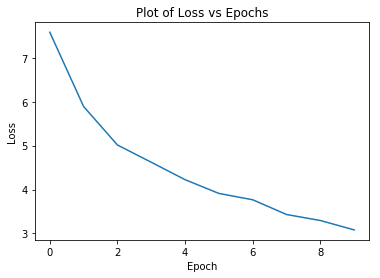

In [65]:
plt.plot(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot of Loss vs Epochs')
plt.show()

In [66]:
model

Resnet18Multiclass(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### Load the best model (based on validation set) and evaluate on test set

In [67]:
#RERUN
model = load_model(model_save + 'best.model')#'best.model')
model_save
torch.save(model.state_dict(), model_save + "model_backup.pt")
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

In [68]:
model_save

'./model/test_for_reformed_dataset/'

In [69]:
test_df

,Thraupis episcopus,Celeus grammicus,Turdus leucomelas,Xiphorhynchus guttatus,Ramphastos tucanus,Trogon viridis,Tolmomyias sulphurescens,no bird,Zonotrichia capensis,Myioborus miniatus,Microcerculus marginatus
file,,,,,,,,,,,
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,0,0,1,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,0,0,1,0,0,0,0


In [70]:
prediction_dataset.df

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Thraupis episcopus,Celeus grammicus,Turdus leucomelas,Xiphorhynchus guttatus,Ramphastos tucanus,Trogon viridis,Tolmomyias sulphurescens,no bird,Zonotrichia capensis,Myioborus miniatus,Microcerculus marginatus
file,,,,,,,,,,,
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,0,0,1,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,0,0,1,0,0,0,0


In [71]:
model_save

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'./model/test_for_reformed_dataset/'

In [72]:
#test_name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/Cosmos_Data/automated_cosmos_tweety_to_file"
#test_df = pd.read_csv(test_name + '_TESTING.csv')

#print(species)
#def fix_classes(label):
#    if (not label in species):
#        return "other"
#    return label
#test_df['MANUAL ID'] = test_df["MANUAL ID"].apply(fix_classes)
#test_df
#classes

In [73]:
#test_name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/Cosmos_Data/automated_cosmos_tweety_to_file"
#test_df = pd.read_csv(test_name + '_TESTING.csv')
#other_bird = test_df[~(test_df["MANUAL ID"].isin(classes))]
#test_df= test_df[(test_df["MANUAL ID"].isin(classes))]
#other_bird["MANUAL ID"] = "bird"
#test_df

In [74]:
#classes

In [75]:

#test_df = test_df.append(other_bird)
#one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
#test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)
#prediction_dataset.df = test_df

In [76]:
prediction_dataset.df = prediction_dataset.df[list(model.classes)]

In [77]:
list(model.classes)

['Thraupis episcopus',
 'Celeus grammicus',
 'Turdus leucomelas',
 'Xiphorhynchus guttatus',
 'Tolmomyias sulphurescens',
 'Ramphastos tucanus',
 'Trogon viridis',
 'no bird',
 'Zonotrichia capensis',
 'Myioborus miniatus',
 'Microcerculus marginatus']

In [78]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 batch_size=16,
                                                                 num_workers=6,
                                                                 activation_layer='softmax')

(6437, 11)


#### Print various metrics for the test set predictions

In [79]:
valid_labels_df

,Thraupis episcopus,Celeus grammicus,Turdus leucomelas,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Ramphastos tucanus,Trogon viridis,no bird,Zonotrichia capensis,Myioborus miniatus,Microcerculus marginatus
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,1,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,1,0,0,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,0,1,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,1,0,0,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.0.wav,0,0,0,0,1,0,0,0,0,0,0


In [80]:
valid_preds_df

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Thraupis episcopus,Celeus grammicus,Turdus leucomelas,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Ramphastos tucanus,Trogon viridis,no bird,Zonotrichia capensis,Myioborus miniatus,Microcerculus marginatus
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.0.wav,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
valid_scores_df

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Thraupis episcopus,Celeus grammicus,Turdus leucomelas,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Ramphastos tucanus,Trogon viridis,no bird,Zonotrichia capensis,Myioborus miniatus,Microcerculus marginatus
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,4.972458e-26,1.000000e+00,1.563251e-34,6.143159e-28,6.064399e-41,9.435185e-30,5.095387e-27,6.591707e-27,3.853505e-39,1.401298e-44,4.515690e-28
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,1.866291e-26,1.000000e+00,1.344803e-19,1.016271e-23,1.448423e-23,3.068328e-21,1.535795e-19,2.001330e-18,3.779789e-26,1.799555e-30,7.428848e-23
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,3.461917e-20,4.034090e-08,8.333595e-18,6.074082e-16,4.913187e-11,7.567393e-13,4.753904e-10,1.000000e+00,9.086862e-14,1.291625e-16,7.842398e-13
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,5.773201e-16,1.000000e+00,1.731269e-15,2.562312e-23,6.930655e-24,6.752102e-17,3.659550e-23,2.228275e-15,5.377400e-23,3.772159e-24,6.127172e-29
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,1.091103e-10,1.000000e+00,1.655865e-20,3.728450e-18,4.974312e-21,8.000787e-12,8.601881e-16,1.087886e-14,1.990163e-16,1.755595e-17,2.006817e-20
...,...,...,...,...,...,...,...,...,...,...,...
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,2.369123e-27,1.145130e-20,3.924040e-17,5.059219e-15,1.000000e+00,1.832231e-21,2.939889e-17,3.479720e-12,3.504313e-29,8.404448e-23,2.530964e-15
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,1.526234e-13,1.102700e-15,1.237377e-06,1.208805e-09,4.901298e-07,8.862877e-12,9.317377e-10,9.995522e-01,3.689009e-10,2.890297e-08,4.460162e-04
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,1.527415e-43,3.024722e-30,6.704680e-29,8.413602e-20,1.000000e+00,3.384822e-26,2.672751e-23,1.389590e-18,8.491869e-42,3.722586e-38,2.673953e-24
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.0.wav,0.000000e+00,2.929035e-22,1.064566e-39,2.570497e-23,1.000000e+00,1.685356e-29,3.218652e-26,1.610117e-22,0.000000e+00,0.000000e+00,1.161565e-31


In [82]:
print(classification_report(valid_labels_df, valid_preds_df, target_names=valid_scores_df.columns))

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                          precision    recall  f1-score   support

      Thraupis episcopus       0.40      0.76      0.53       248
        Celeus grammicus       0.63      0.65      0.64       224
       Turdus leucomelas       0.65      0.86      0.74       493
  Xiphorhynchus guttatus       0.55      0.81      0.66       335
Tolmomyias sulphurescens       0.70      0.76      0.73       368
      Ramphastos tucanus       0.84      0.95      0.89       552
          Trogon viridis       0.51      0.87      0.64       357
                 no bird       0.83      0.39      0.54      2709
    Zonotrichia capensis       0.73      0.81      0.77       398
      Myioborus miniatus       0.48      0.85      0.61       314
Microcerculus marginatus       0.58      0.89      0.70       439

               micro avg       0.65      0.65      0.65      6437
               macro avg       0.63      0.78      0.68      6437
            weighted avg       0.71      0.65      0.64      6437
        

#### Plot the RIC curve and report AOC

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


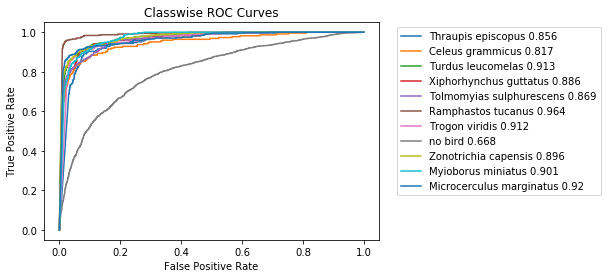

In [83]:

for species in model.classes:
    fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
    auc = roc_auc_score(valid_labels_df[species],  valid_preds_df[species])
    plt.plot(fpr,tpr,label= species + " "+str(round(auc, 3)))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [84]:
model.classes

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Thraupis episcopus',
 'Celeus grammicus',
 'Turdus leucomelas',
 'Xiphorhynchus guttatus',
 'Tolmomyias sulphurescens',
 'Ramphastos tucanus',
 'Trogon viridis',
 'no bird',
 'Zonotrichia capensis',
 'Myioborus miniatus',
 'Microcerculus marginatus']

***Validate Results***

In [85]:
model.predict

<bound method PytorchModel.predict of Resnet18Multiclass(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64

In [86]:
model.train_dataset.sample(n=0)

In [87]:
from sklearn.metrics import confusion_matrix

In [88]:
valid_labels_df[species].values.shape

(6437,)

In [89]:
test = valid_preds_df.apply(lambda x: sum(x) == 1, axis=1)
test[~test]

Series([], dtype: bool)

In [90]:
def label(row):
    for col in row:
        print(row[col])
        if row[col] == 1:
            row[col] = col
    return row

In [91]:
def label(row):
    for col in range(len(valid_labels_df.columns)):
        if row[col] == 1:
            return valid_labels_df.columns[col]
    return "None"

label_confusion = pd.DataFrame(valid_labels_df.apply(label, axis=1))
preds_confusion = pd.DataFrame(valid_preds_df.apply(label, axis=1))

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:424: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


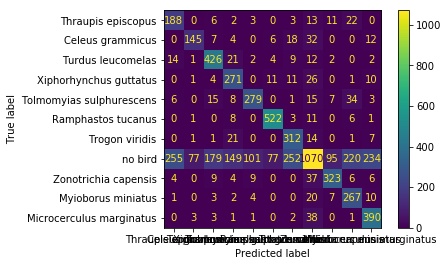

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(label_confusion, preds_confusion,labels=valid_scores_df.columns)
cm_display = ConfusionMatrixDisplay(cm, display_labels=valid_scores_df.columns).plot()

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:424: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


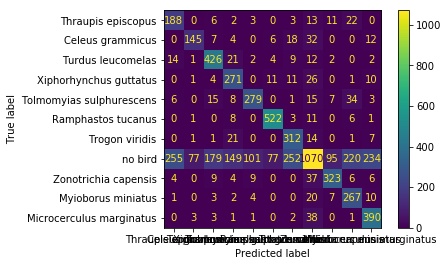

In [93]:
ConfusionMatrixDisplay.from_predictions(label_confusion, preds_confusion,labels=valid_scores_df.columns)

In [94]:
import itertools
def plot_confusion_matrix_2(cm,
                      target_names,
                      title='Tweetynet WTS on Opensoundscape with Mixed Bird Other',
                      cmap=None,
                      normalize=True,
                      FONT_SIZE = 10,
                      figsize = (8*2, 6*2)):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions


    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    https://stackoverflow.com/questions/48855290/plotted-confusion-matrix-values-overlapping-each-other-total-classes-90

    """


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)    # 8, 6
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, fontsize=FONT_SIZE)
        plt.yticks(tick_marks, target_names, fontsize=FONT_SIZE)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


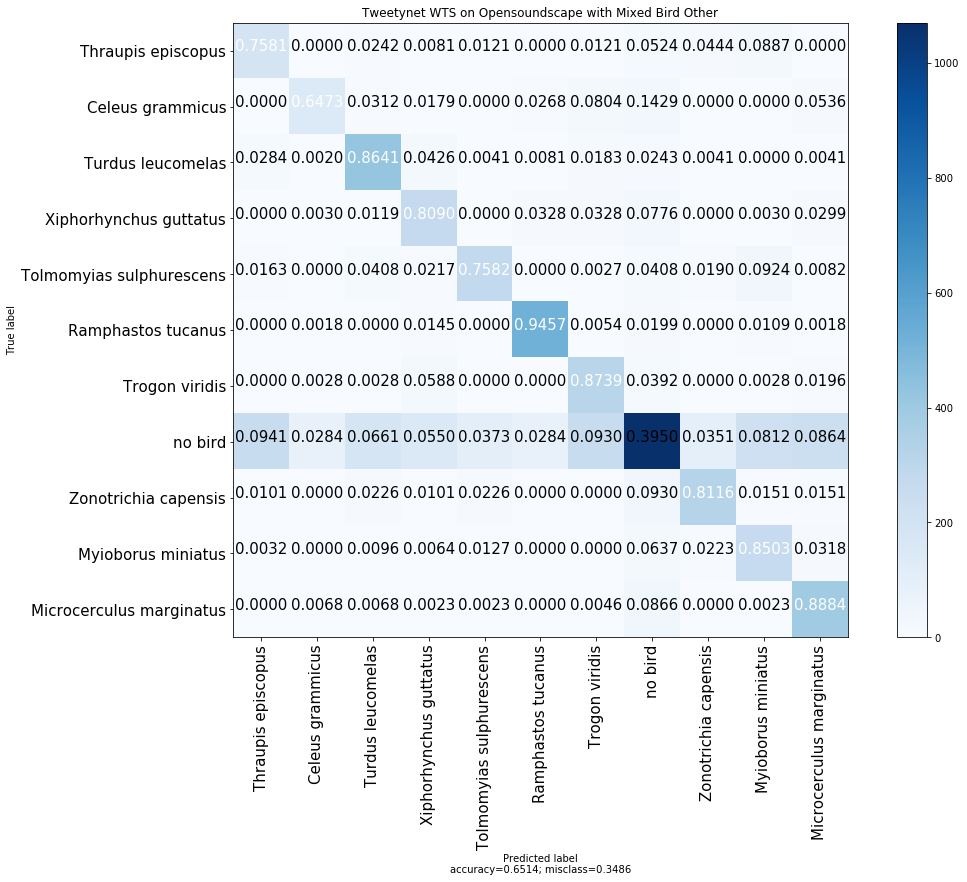

In [95]:
plot_confusion_matrix_2(cm, target_names=valid_scores_df.columns, FONT_SIZE=15)

In [96]:
valid_scores_df["max"] = valid_scores_df.apply(lambda x : max(x), axis=1)



(array([4.000e+00, 1.000e+01, 5.700e+01, 4.500e+01, 7.500e+01, 8.000e+01,
        9.100e+01, 1.020e+02, 1.900e+02, 5.783e+03]),
 array([0.36219963, 0.42597967, 0.48975971, 0.55353974, 0.61731978,
        0.68109982, 0.74487985, 0.80865989, 0.87243993, 0.93621996,
        1.        ]),
 <a list of 10 Patch objects>)

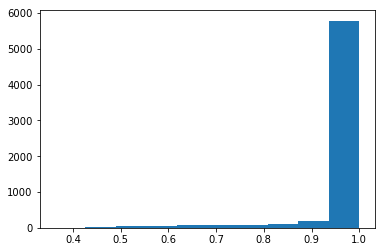

In [97]:
plt.hist(valid_scores_df["max"].values)

(array([  4.,  10.,  54.,  45.,  67.,  85.,  84., 105., 159., 435.]),
 array([0.36219963, 0.42497228, 0.48774493, 0.55051757, 0.61329022,
        0.67606287, 0.73883551, 0.80160816, 0.86438081, 0.92715345,
        0.9899261 ]),
 <a list of 10 Patch objects>)

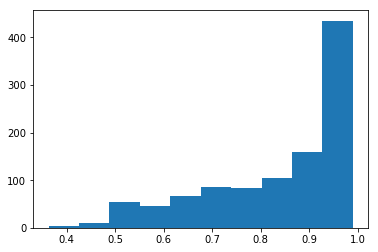

In [98]:
plt.hist(valid_scores_df[valid_scores_df["max"] < 0.99]["max"].values)

In [99]:
valid_scores_df[valid_scores_df["max"] > 0.99].shape

(5389, 12)

In [100]:
valid_scores_df[valid_scores_df["max"] < 0.99].shape

(1048, 12)

In [101]:
#plt.hist(valid_scores_df[~(valid_scores_df["other"] >= valid_scores_df["max"]-0.01)]["max"].values)

In [102]:
#plt.hist(valid_scores_df[~(valid_scores_df["other"] >= valid_scores_df["max"]-0.01) & (valid_scores_df["max"] > 0.99)]["max"].values)

In [103]:
#plt.hist(valid_scores_df[valid_scores_df["other"] >= valid_scores_df["max"]-0.01]["max"].values)

In [104]:

#for  col in valid_scores_df.columns:
#    plot.plot
#    plt.hist(valid_scores_df[valid_scores_df[col] >= valid_scores_df["max"]-0.01]["max"].values)

In [105]:
valid_scores_df.shape

(6437, 12)

In [106]:
custom_pred_df = valid_scores_df.copy(deep=True)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:424: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


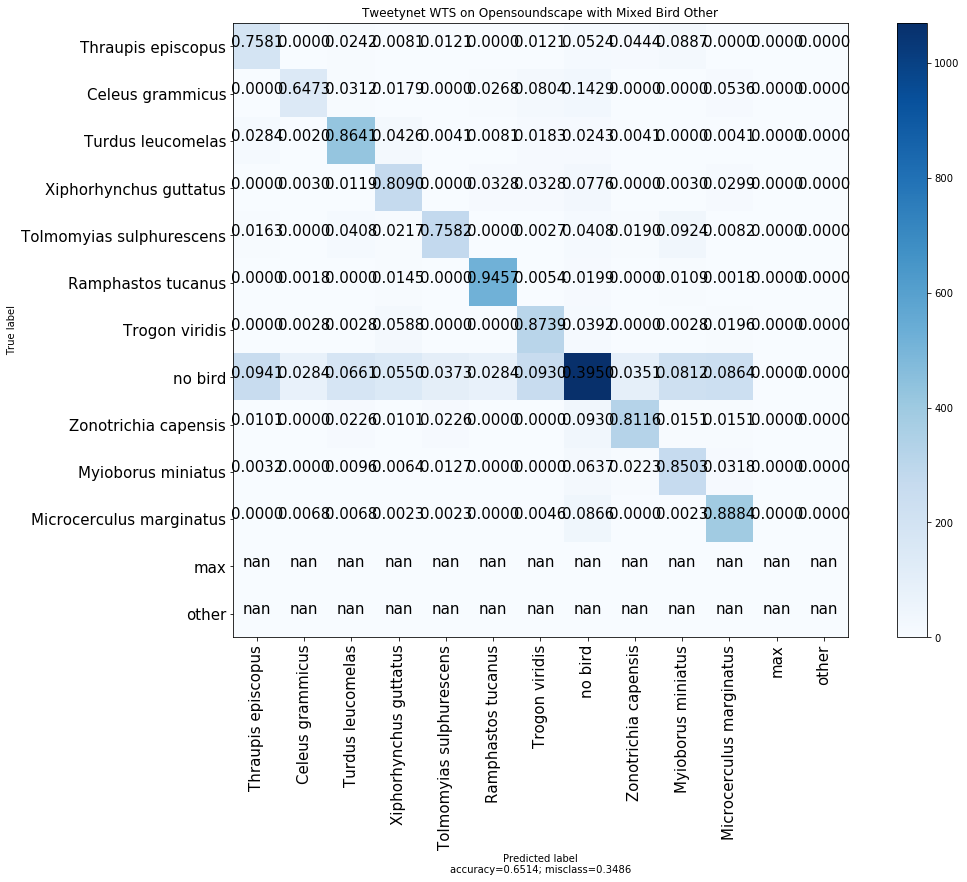

In [107]:
def thresholding(row, threshold=0.20):
    return_row = row.copy()
    for index in row.index:
        return_row[index] = 0

    meets_threshold = False
    for index in row.index:
        if index == "max":
            continue
        if row[index] == row["max"] and row["max"] > threshold and not meets_threshold:
            return_row[index] = 1
            meets_threshold = True
    if (not meets_threshold):
        return_row["other"] = 1
    return return_row

valid_scores_df["other"] = 0
custom_pred_df = valid_scores_df.apply(thresholding, axis=1)
custom_pred_df

def label(row):
    for col in range(len(valid_labels_df.columns)):
        if row[col] == 1:
            return valid_labels_df.columns[col]
    return "other"

label_confusion = pd.DataFrame(valid_labels_df.apply(label, axis=1))
preds_confusion = pd.DataFrame(valid_preds_df.apply(label, axis=1))
preds_confusion_custom = pd.DataFrame(custom_pred_df.apply(label, axis=1))

cm = confusion_matrix(label_confusion, preds_confusion_custom,labels=valid_scores_df.columns)
plot_confusion_matrix_2(cm, target_names=valid_scores_df.columns, FONT_SIZE=15)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:424: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


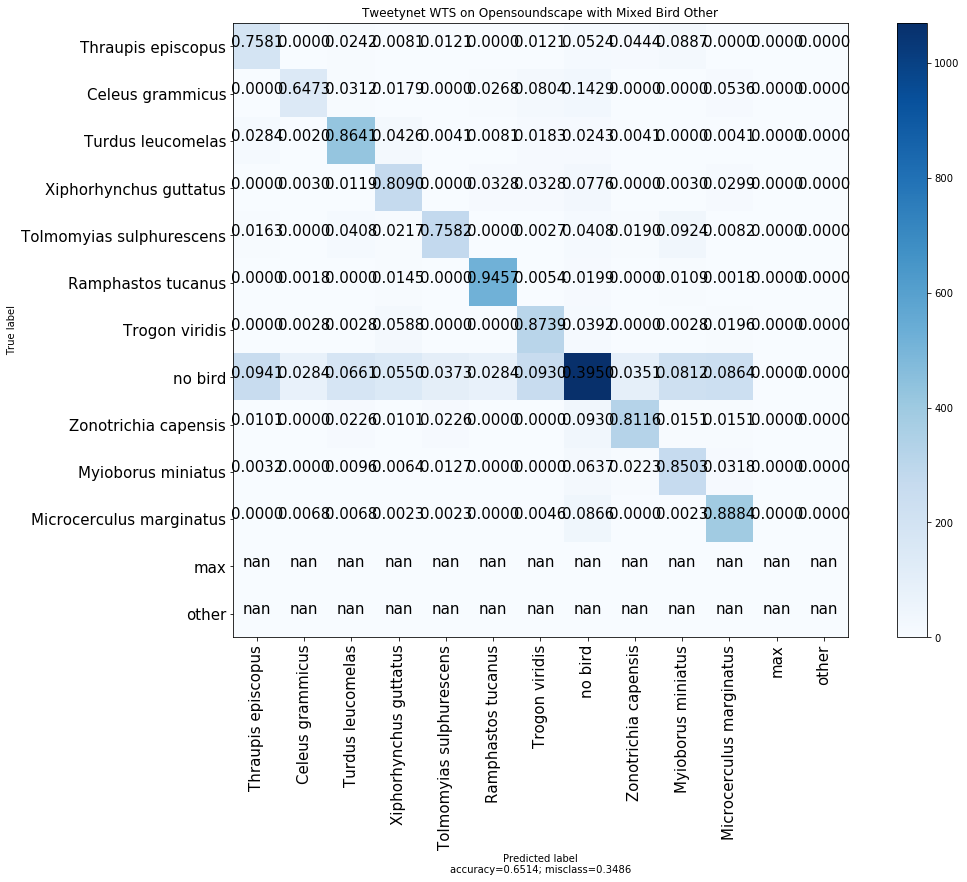

In [108]:

cm = confusion_matrix(label_confusion, preds_confusion_custom,labels=valid_scores_df.columns)
plot_confusion_matrix_2(cm, target_names=valid_scores_df.columns, FONT_SIZE=15)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


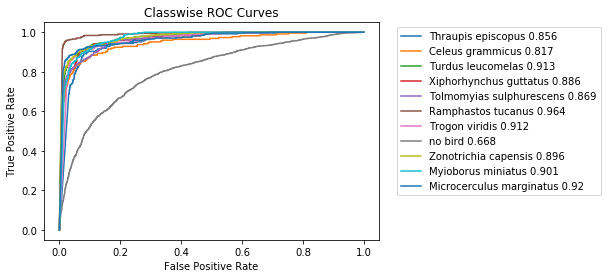

In [109]:

for species in model.classes:
    fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
    auc = roc_auc_score(valid_labels_df[species],  custom_pred_df[species])
    plt.plot(fpr,tpr,label= species + " "+str(round(auc, 3)))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [110]:
custom_pred_df = custom_pred_df.drop("max", axis=1)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
def add_other_labels_valid(row):
    if (sum(row) == 0):
        return 1
    return 0
valid_labels_df["other"] = valid_labels_df.apply(add_other_labels_valid, axis=1)
valid_labels_df

,Thraupis episcopus,Celeus grammicus,Turdus leucomelas,Xiphorhynchus guttatus,Tolmomyias sulphurescens,Ramphastos tucanus,Trogon viridis,no bird,Zonotrichia capensis,Myioborus miniatus,Microcerculus marginatus,other
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,1,0,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,1,0,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,1,0,0,0,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,1,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,1,0,0,0,0,0,0,0
./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.0.wav,0,0,0,0,1,0,0,0,0,0,0,0


In [112]:
print(classification_report(valid_labels_df, custom_pred_df, target_names=custom_pred_df.columns))

                          precision    recall  f1-score   support

      Thraupis episcopus       0.40      0.76      0.53       248
        Celeus grammicus       0.63      0.65      0.64       224
       Turdus leucomelas       0.65      0.86      0.74       493
  Xiphorhynchus guttatus       0.55      0.81      0.66       335
Tolmomyias sulphurescens       0.70      0.76      0.73       368
      Ramphastos tucanus       0.84      0.95      0.89       552
          Trogon viridis       0.51      0.87      0.64       357
                 no bird       0.83      0.39      0.54      2709
    Zonotrichia capensis       0.73      0.81      0.77       398
      Myioborus miniatus       0.48      0.85      0.61       314
Microcerculus marginatus       0.58      0.89      0.70       439
                   other       0.00      0.00      0.00         0

               micro avg       0.65      0.65      0.65      6437
               macro avg       0.58      0.72      0.62      6437
        

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

In [113]:
valid_labels_df.shape


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6437, 12)

In [114]:
custom_pred_df.shape

(6437, 12)